# Globalna Analiza Zanieczyszczeń Powietrza - PM10, PM2.5 I NO2


## 1. Wstęp

W analizie skupiono się głównie na wymiarze przestrzennym analizowanych danych. Zrozumiałe jest, że dane pochodzą z wielu lat i nie ma zachowanej spójności czasowej.

Przed przystąpieniem do analizy przestrzennej, nastąpiło uporządkowanie wymiaru czasowego - poprzez lekkie okrojenie oryginalych danych.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("who_aap_2021_v9_11august2022.xlsx", sheet_name="AAP_2022_city_v9")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "").str.replace("/", "_").str.lower()

## 2. EDA

### 2.1 EDA - Wymiar Czasowy

Najstarsze pomiary pochodziły z roku 2000.

Najnowsze z 2021 roku.

In [2]:
print(df.measurement_year.min())
print(df.measurement_year.max())

2000
2021


Początkowo było 32191 wierszy.

In [3]:
len(df)

32191

Pomiarów starszych niż rok 2010 i nowszych niż 2019 była znikoma ilość więc się ich pozbyto z dalszej analizy - w celu usprawnienie spójności czasowej pomiarów.

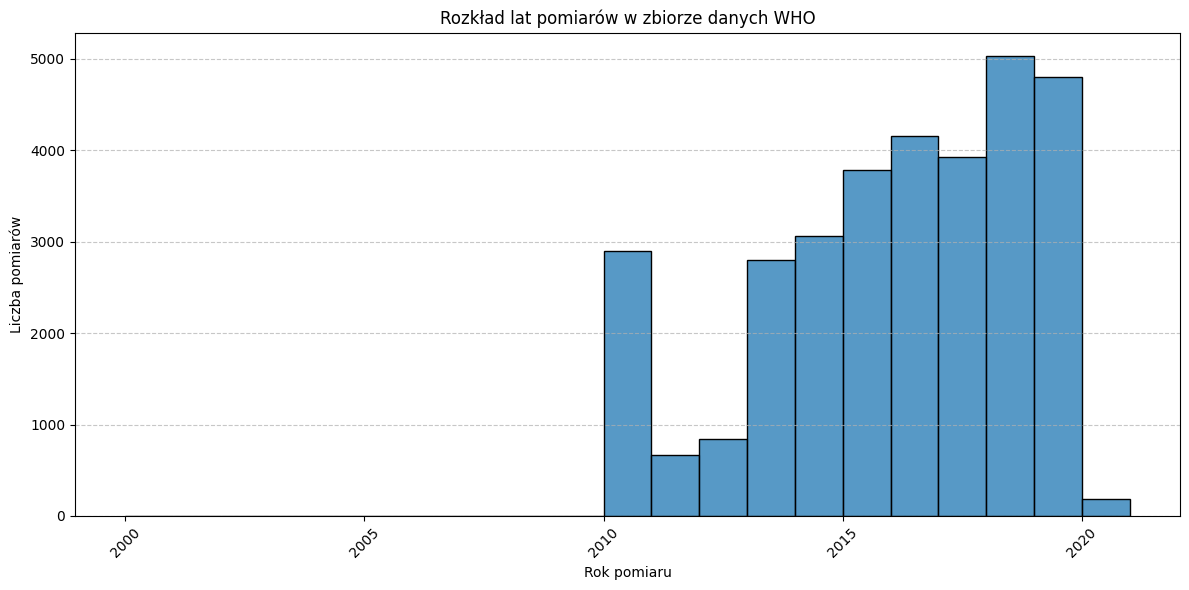

In [4]:
# Wykres - liczba pomiarów w poszczególnych latach
plt.figure(figsize=(12, 6))
sns.histplot(df["measurement_year"], bins=range(df["measurement_year"].min(), df["measurement_year"].max() + 1), kde=False)

plt.title("Rozkład lat pomiarów w zbiorze danych WHO")
plt.xlabel("Rok pomiaru")
plt.ylabel("Liczba pomiarów")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim()
plt.tight_layout()
plt.show()

In [5]:
df = df[df['measurement_year'] >= 2010]
df = df[df['measurement_year'] <= 2019]

Po wstępnej filtracji zostało 31987 wierszy. Utracono bardzo niewiele rekordów ale zyskano znacznie bardziej jednostajny rozkład danych pomiarowych w wymiarze czasowym.

In [6]:
len(df)

31987

Średnia roczna ilość pomiarów wynosi 3199. Lata 2015>= dostarczały więcej danych 

Lata 2015< mniej niż ogólna średnia. 

Powodem, może być nacisk od strony WHO w celu zwiększenia transperentości o zanieczyszczeniu środowiska.

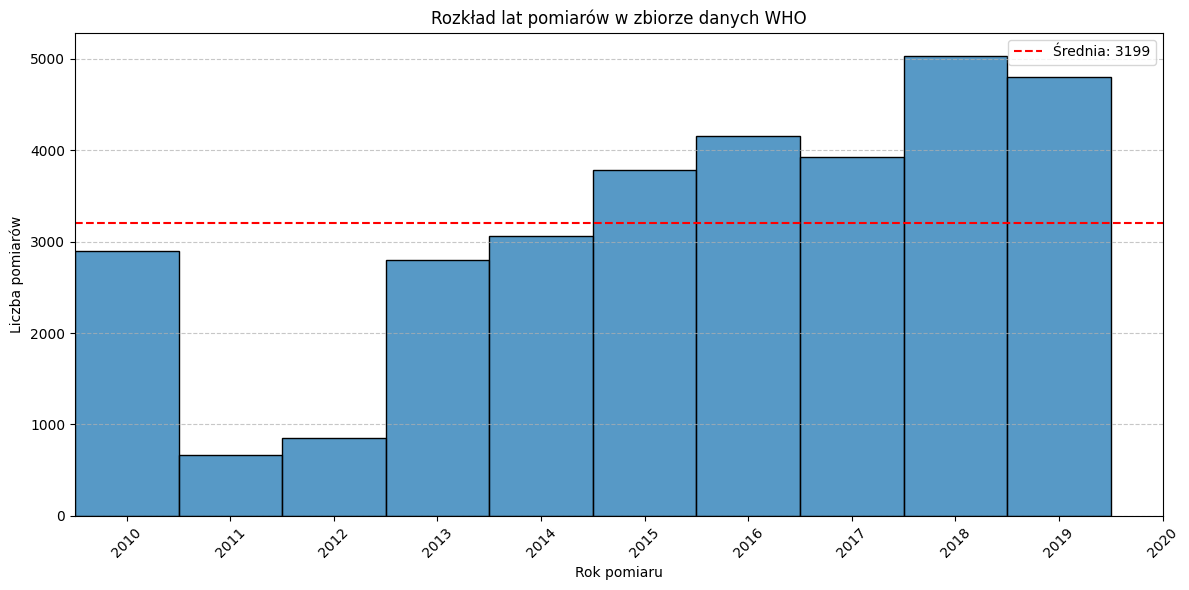

In [7]:
plt.figure(figsize=(12, 6))

# Histogram
sns.histplot(df["measurement_year"], bins=range(df["measurement_year"].min(), df["measurement_year"].max()+2), kde=False)

# Obliczenie średniej liczby pomiarów na rok
counts_per_year = df["measurement_year"].value_counts().sort_index()
mean_measurements_per_year = counts_per_year.mean()

# Dodanie poziomej linii
plt.axhline(mean_measurements_per_year, color="red", linestyle="--", label=f"Średnia: {mean_measurements_per_year:.0f}")

# Tytuły i opisy
plt.title("Rozkład lat pomiarów w zbiorze danych WHO")
plt.xlabel("Rok pomiaru")
plt.ylabel("Liczba pomiarów")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Ustaw limity osi x
plt.xlim(df["measurement_year"].min(), df["measurement_year"].max())

# Nowe xticks - na środku binów
tick_positions = [year + 0.5 for year in range(2010, 2021)]
tick_labels = list(range(2010, 2021))
plt.xticks(tick_positions, tick_labels, rotation=45)

# Legenda
plt.legend()

plt.tight_layout()
plt.show()


### Nie uwzględniono zmiennych o pokryciu czasowym

Ze względu na małą dostępność danych pomiarowych o charakterze "pokrycie czasowe" dla PM10 i PM2.5 nie zostanę one uwzględnione w dalszej analizie.

Ilość danych jest niewystarczająca, nawet jeśli dokonano by imputacji. Informacje nie odzwierciedlały by prawdy, dodatkowo ciężko byłoby określić jak pokrycie czasowe wpływa na roczny poziom zanieczyszczenia.

Sam fakt, tak dużej ilości brakujących danych o pokryciu czasowym świadczy negatywnie o jakości tego zbioru danych i o jego wiarygodności.

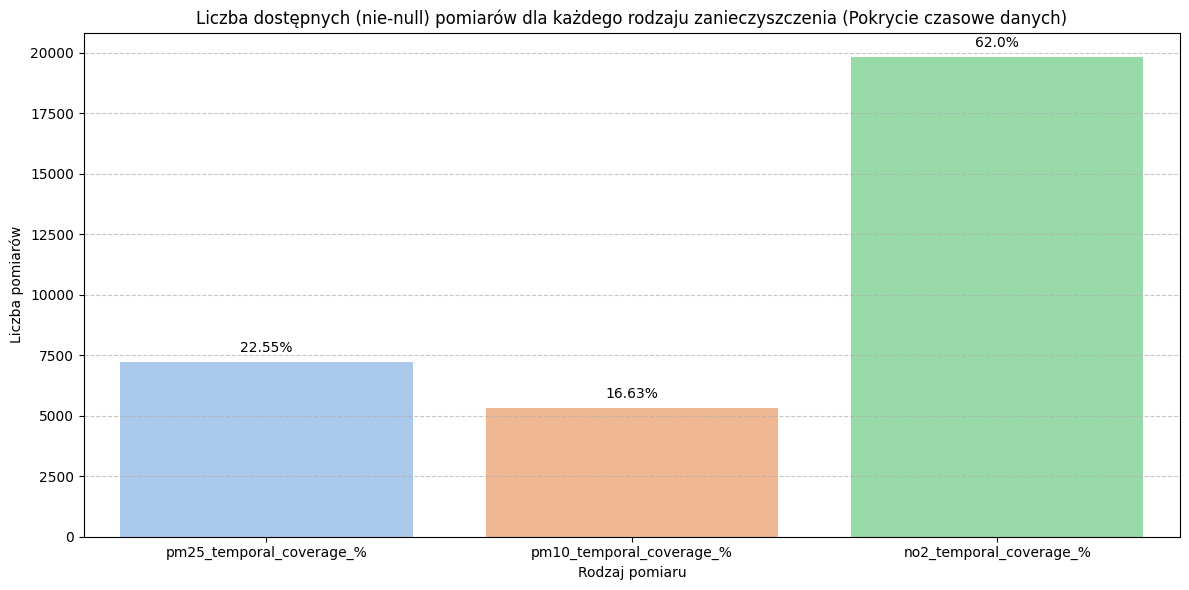

In [8]:
# Liczba nie-null dla każdego parametru
non_null_counts = df[["pm25_temporal_coverage_%", "pm10_temporal_coverage_%", "no2_temporal_coverage_%"]].notnull().sum()
non_null_counts = non_null_counts.reset_index()
non_null_counts.columns = ["Rodzaj_pomiaru", "Liczba_pomiarów"]

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=non_null_counts, x="Rodzaj_pomiaru", y="Liczba_pomiarów",hue="Rodzaj_pomiaru", palette="pastel")

# Tytuł i etykiety
plt.title("Liczba dostępnych (nie-null) pomiarów dla każdego rodzaju zanieczyszczenia (Pokrycie czasowe danych)")
plt.xlabel("Rodzaj pomiaru")
plt.ylabel("Liczba pomiarów")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Dodanie wartości liczbowych nad słupkami
for index, row in non_null_counts.iterrows():
    percent_share = row.Liczba_pomiarów / len(df) * 100
    plt.text(index, row.Liczba_pomiarów + 300, f'{round(percent_share,2)}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
df = df.drop(['pm25_temporal_coverage_%','pm10_temporal_coverage_%','no2_temporal_coverage_%'],axis=1)

### 2.2 ITables 2.0

Przy tak dużym zbiorze danych, gdzie analizujemy cały świat a analiza ma charakter zbiorczy. Wykorzystanie bibltioteki ITables jest dobrym narzędziem do wstępnej inspekcji danych. 

Przy dalszych etapach analizy może się przydać do inspekcji danych zaagregowanych na różnych poziomach generalizacji, im wyższy stopień generalizacji tym lepiej działa ITables.

In [10]:
from itables import show
import itables

# Konfiguracja opcji ITables
itables.options.lengthMenu = [10, 25, 50, 100]
itables.options.columnDefs = [{"width": "200px", "targets": "_all"}]

# Wyświetlenie interaktywnej tabeli
show(df)

Po inspekcji przy użyciu ITables, zdecydowano na pozbycie się również zmiennych:

- reference - Odwołanie do źródła danych, ta informacja przy analizie przestrzennej nie ma znaczenia, ponieważ nie skupiano się na polityczo-administracyjnych powiązaniach
- number_and_type_of_monitoring_stations - informacje o ilości i rodzaju nie są potrzebne. Zakładamy, że dane pochodzą z przynajmniej jednej stacji pomiarowej. A jeśli było ich więcej to są to dane uśrednione.
- version_of_the_database - niepotrzebna informacja
- status - cała kolumna jest Null

In [11]:
df = df.drop(['reference', 'number_and_type_of_monitoring_stations',
       'version_of_the_database', 'status'],axis=1)
df.index.name = 'id'

### <strong>Duplikaty</strong>

Wygląda na to, że w zbiorze danych występują 102 duplikaty. 

Mało prawdopodbne jest, żeby w tym samym mieście w tym samym roku stacje pomiarowe dostarczyły dokładnie takie same wyniki pomiarowe.

In [12]:
show(df[df.duplicated(subset=['city_or_locality','measurement_year','pm2.5_μg_m3','pm10_μg_m3','no2_μg_m3'],keep=False)].sort_values(by=['city_or_locality','measurement_year']))

Usunięto duplikaty

In [13]:
df = df.drop_duplicates(subset=['city_or_locality', 'measurement_year', 'pm2.5_μg_m3', 'pm10_μg_m3', 'no2_μg_m3'])

Po okrojeniu danych, tak prezentował się zbiór danych - jest bardziej przejrzysty i łatwiejszy w analizie

In [14]:
show(df)

Z brakującymi danymi pomiarowymi zdecydowano nic nie robić na tym etapie.

Aczkolwiek brakująca wartość w who_region wymaga uzupełnienia przed analizą przestrzenną.

In [15]:
df.isna().sum()

who_region              1
iso3                    0
who_country_name        0
city_or_locality        0
measurement_year        0
pm2.5_μg_m3         17014
pm10_μg_m3          11043
no2_μg_m3            9930
dtype: int64

Liechtenstein leży w regionie European Region

In [16]:
display(df[df.who_region.isna()])
df.loc[df['who_region'].isna(), 'who_region'] = 'European Region'

,who_region,iso3,who_country_name,city_or_locality,measurement_year,pm2.5_μg_m3,pm10_μg_m3,no2_μg_m3
id,,,,,,,,
24778,NaN,LIE,Liechtenstein,Vaduz,2010,NaN,17.88,23.59


### 2.3 EDA - Wymiar Przestrzenny

### <strong>Poziom - Miasta</strong>

Na poziomie miast, skupiono się na klasycznej eksploracyjnej analizie danych

W zbiorze danych jest 6866 miast lub regionów lokalnych. To wskazuje na utrudnioną analizę poprzez wizualizacje przestrzenną. Przy takiej ilości punktów pomiarowych analiza i interpretacja wizualizacji mapy byłaby nie-miarodajna. 

Dodatkowo, zbiór danych nie zawiera geolokalizacji miast, a mapowanie po nazwach miejscowości mogłoby się nie udać. Więc wizualizacja mapy miast została pominięta.

In [17]:
df.city_or_locality.nunique()

6866

<strong>Analiza rozkładów danych </strong>

Wszystkie rozkłady danych są asymetryczne prawostronne. 

PM2.5 skupia się w przedziale od 0 do 30. Szczyt wykresu jest przesunięty względem średniej. Powodem jest wiele wartości zaoobserowowanych w przedziale 30>.

PM10 jest mocniej skupiony wookół średniej, która jest relatywnie blisko szczytu wykresu - mniej outlierów niż PM2.5

Dwutlenek azotu jest najmniej asymetryczny. Szczyt wykresu i średnia prawie się pokrywają. Występuje najmniej outlierów.

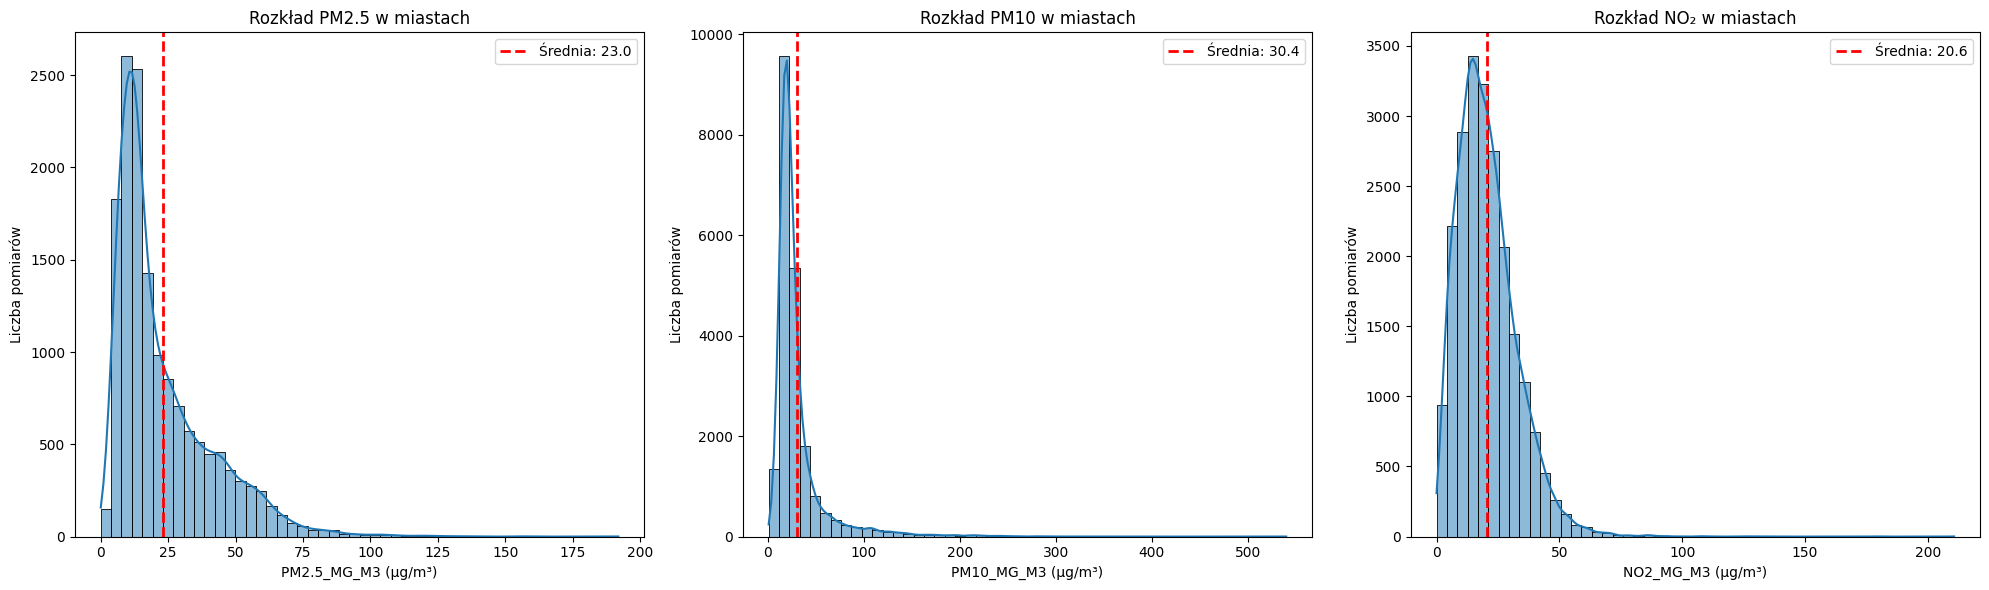

In [18]:
# Tworzymy figurę i 3 podwykresy (1 wiersz, 3 kolumny)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 wiersz, 3 kolumny

# Lista kolumn i tytułów
pollutants = ["pm2.5_μg_m3", "pm10_μg_m3", "no2_μg_m3"]
titles = ["Rozkład PM2.5 w miastach", "Rozkład PM10 w miastach", "Rozkład NO₂ w miastach"]

# Generowanie wykresów
for ax, pollutant, title in zip(axes, pollutants, titles):
    sns.histplot(df[pollutant], bins=50, kde=True, ax=ax)
    
    # Obliczanie średniej
    mean_value = df[pollutant].mean()
    
    # Dodanie linii średniej
    ax.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Średnia: {mean_value:.1f}')
    
    # Ustawienia wykresu
    ax.set_title(title)
    ax.set_xlabel(f"{pollutant.upper()} (μg/m³)")
    ax.set_ylabel("Liczba pomiarów")
    ax.legend()

plt.tight_layout()
plt.show()



<strong>Analiza ilości brakujących danych</strong>

Najwięcej danych pomiarowych jest dla dwutlenku azotu a najmniej dla PM2.5, różnica jest dosyć drastyczna (ponad 20 procentowa różnica w dostępności danych)

Jest to bardzo ciekawe, ponieważ z tych trzech zanieczyszczeń to PM2.5 jest najbardziej szkodliwe. 

Dane pochodzę od WHO, które ustala roczne dopuszczalne limity zanieczyszczenia powietrza.
Można podejrzewać, że niektóre dane pomiarowe są zatajane / nie udostępniane, ze względu na strach przed reperkusjami.

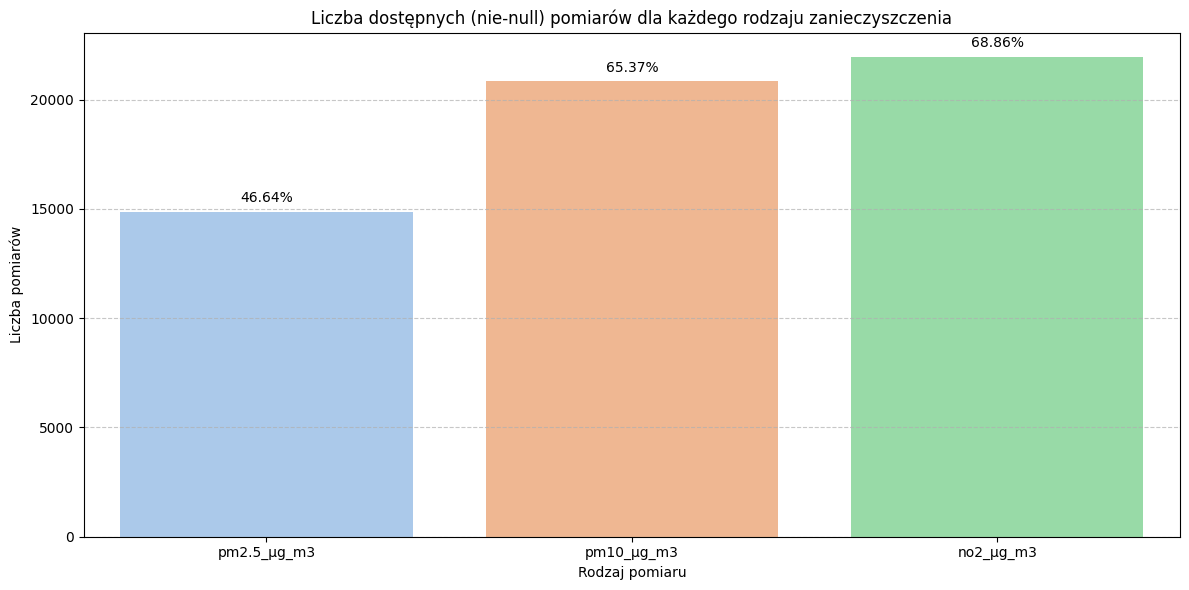

In [19]:
# Liczba nie-null dla każdego parametru
non_null_counts = df[["pm2.5_μg_m3", "pm10_μg_m3", "no2_μg_m3"]].notnull().sum()
non_null_counts = non_null_counts.reset_index()
non_null_counts.columns = ["Rodzaj_pomiaru", "Liczba_pomiarów"]

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(data=non_null_counts, x="Rodzaj_pomiaru", y="Liczba_pomiarów",hue="Rodzaj_pomiaru", palette="pastel")

# Tytuł i etykiety
plt.title("Liczba dostępnych (nie-null) pomiarów dla każdego rodzaju zanieczyszczenia")
plt.xlabel("Rodzaj pomiaru")
plt.ylabel("Liczba pomiarów")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Dodanie wartości liczbowych nad słupkami
for index, row in non_null_counts.iterrows():
    percent_share = row.Liczba_pomiarów / len(df) * 100
    plt.text(index, row.Liczba_pomiarów + 300, f'{round(percent_share,2)}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<strong>Najbardziej i najmniej zanieczyszczone miasta</strong>

Do tego zestawu wykresów uwzględniono aspekt regionalny, by móc wstępnie określić zależności na większą skalę.

Na podstawie "topowych miast" można wnioskować że najbardziej zanieczyszczone regiony to:

- Eastern Mediterranean Region
- South East Asia Region

Najmniej zanieczyszczony jest:

- European Region

Wykresy również, przedstawiają jakie drastyczne różnice w jakości powietrza występują pomiędzy miastami.

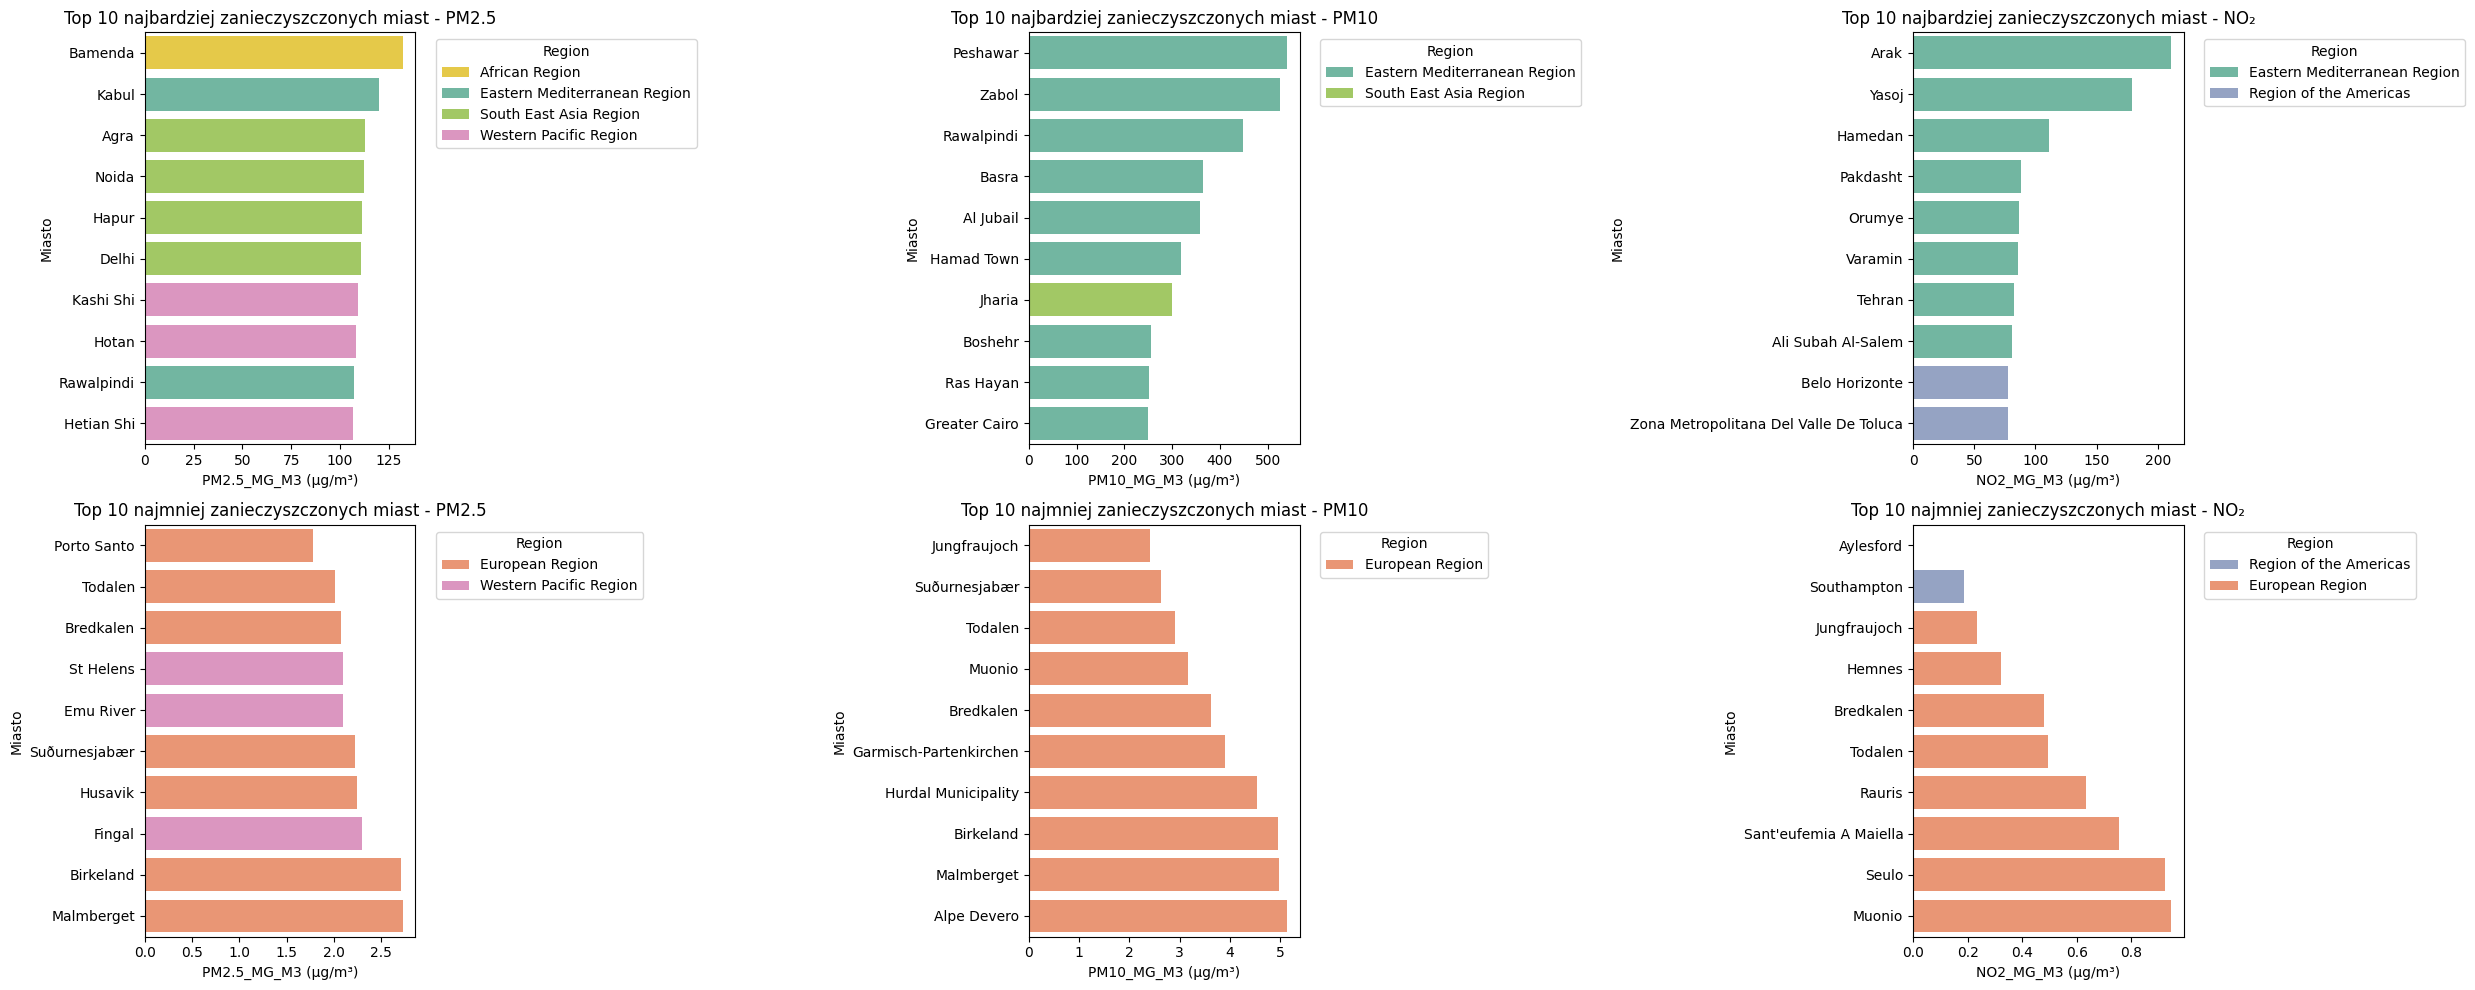

In [20]:
# Tworzymy figure
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
axes = axes.flatten()

pollutants = ["pm2.5_μg_m3", "pm10_μg_m3", "no2_μg_m3"]
titles = [
    "Top 10 najbardziej zanieczyszczonych miast - PM2.5", "Top 10 najmniej zanieczyszczonych miast - PM2.5",
    "Top 10 najbardziej zanieczyszczonych miast - PM10", "Top 10 najmniej zanieczyszczonych miast - PM10",
    "Top 10 najbardziej zanieczyszczonych miast - NO₂", "Top 10 najmniej zanieczyszczonych miast - NO₂"
]


# Stała paleta kolorów
regions = ['Eastern Mediterranean Region', 'European Region', 'Region of the Americas', 
           'Western Pacific Region', 'South East Asia Region', 'African Region']
palette_colors = sns.color_palette("Set2", len(regions))
region_palette = dict(zip(regions, palette_colors))

# Generowanie wykresów
for i, pollutant in enumerate(pollutants):
    # Top 10
    top10 = df[["city_or_locality", "who_region", pollutant]].dropna()
    top10 = top10.groupby(["city_or_locality", "who_region"])[pollutant].mean().reset_index()
    top10 = top10.sort_values(pollutant, ascending=False).head(10)

    sns.barplot(
        data=top10, x=pollutant, y="city_or_locality",
        hue="who_region", dodge=False, ax=axes[i], palette=region_palette
    )
    axes[i].set_title(titles[i*2])
    axes[i].set_xlabel(f"{pollutant.upper()} (μg/m³)")
    axes[i].set_ylabel("Miasto")
    axes[i].legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Bottom 10
    bottom10 = df[["city_or_locality", "who_region", pollutant]].dropna()
    bottom10 = bottom10.groupby(["city_or_locality", "who_region"])[pollutant].mean().reset_index()
    bottom10 = bottom10.sort_values(pollutant, ascending=True).head(10)

    sns.barplot(
        data=bottom10, x=pollutant, y="city_or_locality",
        hue="who_region", dodge=False, ax=axes[i+3], palette=region_palette
    )
    axes[i+3].set_title(titles[i*2 + 1])
    axes[i+3].set_xlabel(f"{pollutant.upper()} (μg/m³)")
    axes[i+3].set_ylabel("Miasto")
    axes[i+3].legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

# Upiększenia
plt.tight_layout()
plt.show()


### <strong>Poziom - Kraje</strong>

Na poziomie krajowym, skupiono się na analizie map.

Przeanalizowano średnie poziomy zanieczyszczeń na dostępnych danych (bez imputacji).

Oraz udział brakujących danych per kraj - w celu rozpoznania zależności przestrzennych na poziomie krajowym.

Roczne limity wyznaczone przez WHO. 

Zakres od 0 do <strong>Roczny limit WHO</strong> będzie traktowany jako kategoria <strong>Bardzo Dobry</strong>.

Pozostałe kategorie zostały wyznaczone arbitralnie.

| Zanieczyszczenie | Roczny limit WHO | Jednostka                | Uwagi                                                                 |
|:-----------------|:-----------------|:-------------------------|:---------------------------------------------------------------------|
| **PM2.5**         | **5 µg/m³**       | mikrogramów na metr sześcienny | bardzo zaostrzony względem wcześniejszych (było 10 µg/m³)             |
| **PM10**          | **15 µg/m³**      | mikrogramów na metr sześcienny | wcześniej było 20 µg/m³                                               |
| **NO₂**           | **10 µg/m³**      | mikrogramów na metr sześcienny | znaczące obniżenie w porównaniu do wcześniejszych wytycznych          |


Potwierdza się teoria, wyznaczona przy wykresach "topowych miast". Kraje Europejskie i Ameryki mają najlepszą jakość powietrza pod względem PM10.

Najgorsza jakość powietrza widoczna jest w krajach azjatyckich i afrykańskich. Tam też jest najwięcej całkowicie (zero rekordów) brakujących danych.

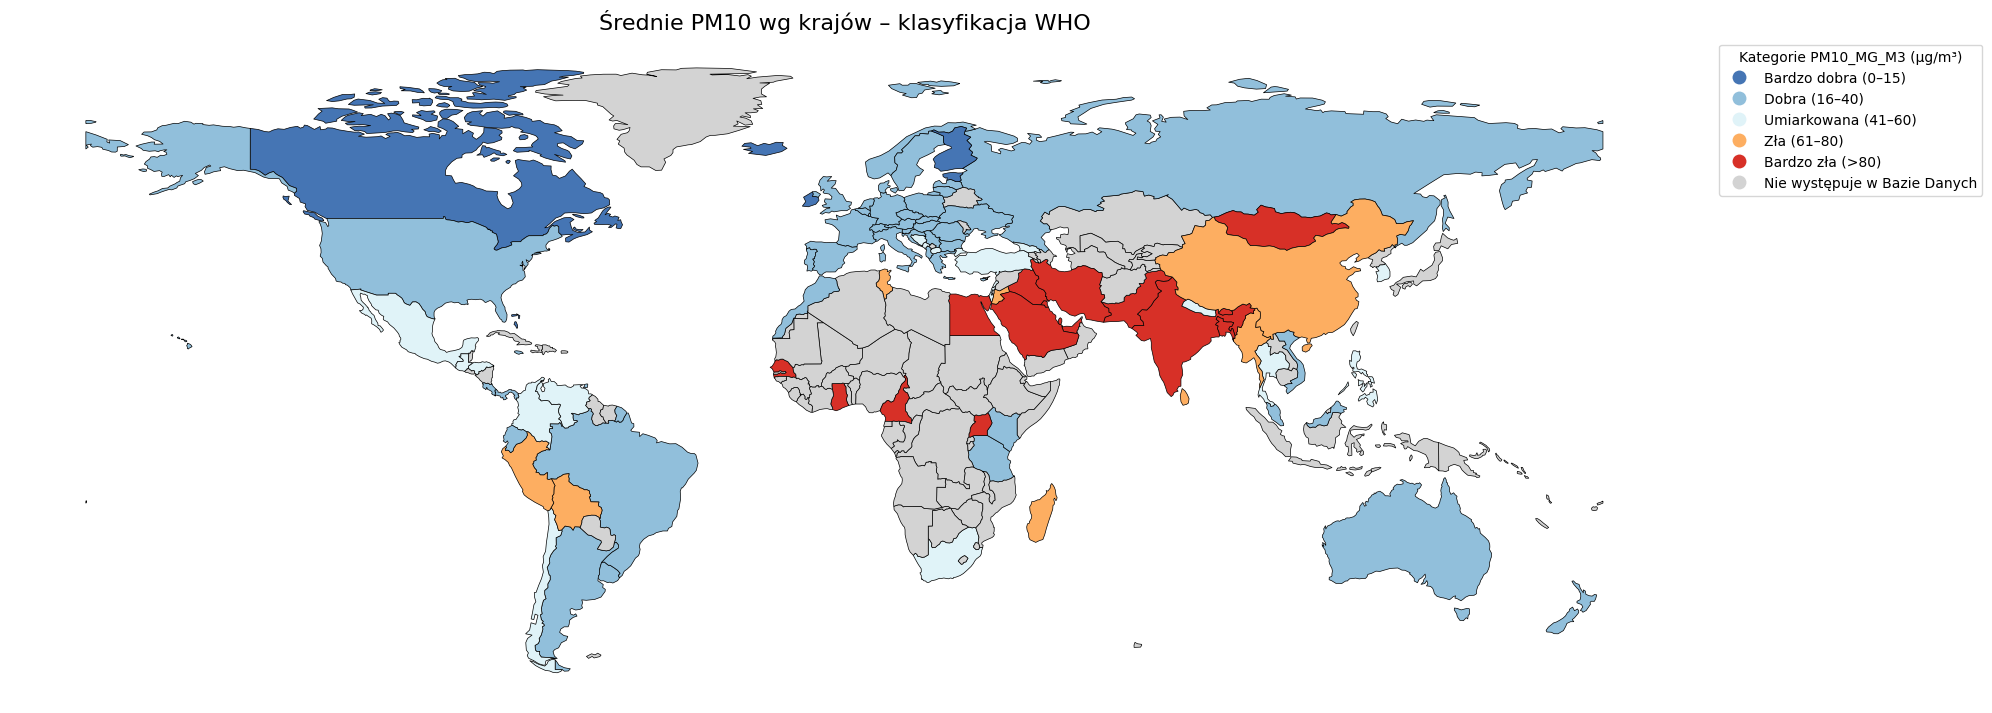

In [21]:
from utilities import plot_air_quality_map, plot_region_level_map
dane = plot_air_quality_map(
    df=df,
    value_col="pm10_μg_m3",
    title="Średnie PM10 wg krajów – klasyfikacja WHO",
    filename="mapa_pm10.png",
    bins=[0, 15, 40, 60, 80, float("inf")],
    labels=[
        "Bardzo dobra (0–15)",
        "Dobra (16–40)",
        "Umiarkowana (41–60)",
        "Zła (61–80)",
        "Bardzo zła (>80)"
    ]
)
dane = dane[['who_country_name','category']]

Średnio - tylko 6 państw utrzymywało ustalony limit z 2021 roku w poziomach PM10. To niewiele.

In [22]:
dane[dane['category'] == 'Bardzo dobra (0–15)']

,who_country_name,category
3,Canada,Bardzo dobra (0–15)
19,Bahamas,Bardzo dobra (0–15)
120,Estonia,Bardzo dobra (0–15)
133,Ireland,Bardzo dobra (0–15)
144,Iceland,Bardzo dobra (0–15)
151,Finland,Bardzo dobra (0–15)


Aż 16 miało średnio roczny wynik powyżej 80. Co jest prawie 6-krotnym przebiciem wyznaczonego limitu. 

In [23]:
dane[dane['category'] == 'Bardzo zła (>80)']

,who_country_name,category
51,Senegal,Bardzo zła (>80)
57,Cameroon,Bardzo zła (>80)
59,Ghana,Bardzo zła (>80)
84,United Arab Emirates,Bardzo zła (>80)
85,Qatar,Bardzo zła (>80)
86,Kuwait,Bardzo zła (>80)
87,Iraq,Bardzo zła (>80)
97,Mongolia,Bardzo zła (>80)
98,India,Bardzo zła (>80)
99,Bangladesh,Bardzo zła (>80)


Europa i Ameryki poza niskimi poziomami PM10 charakteryzuje się dobrą dostępnością danych PM10. Czego nie można powiedzieć o Azji i Afryce.

Choć panśtwa Afrykańskie, które występują w zbiorze danych mają braki danych głównie na poziomie <10%.

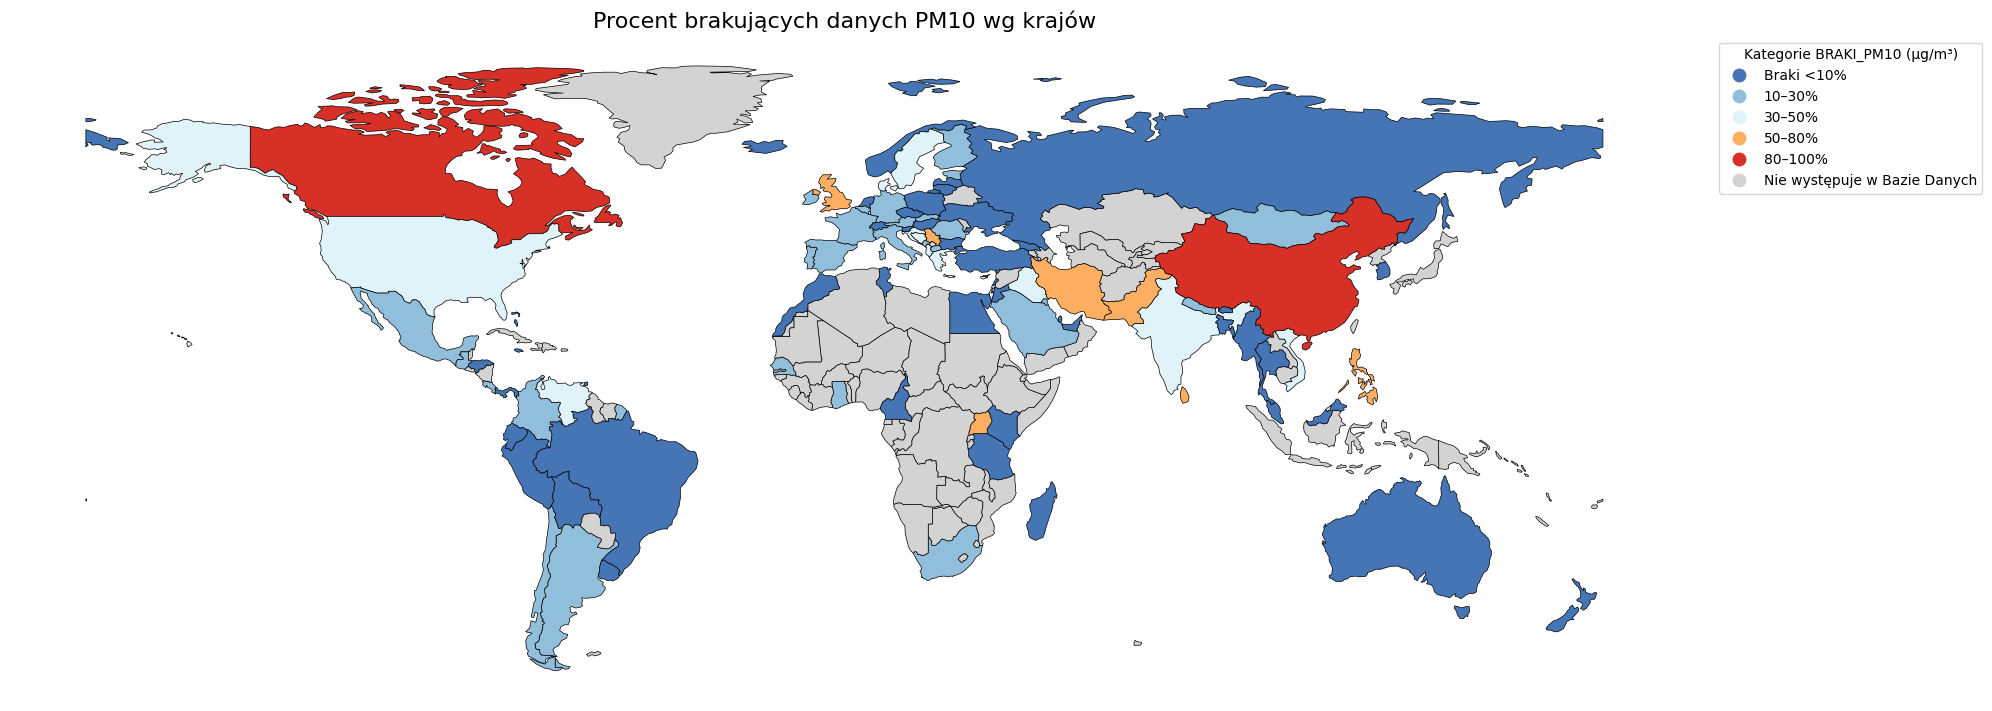

In [24]:
missing_pm10 = (
    df.groupby(["iso3", "who_country_name"])["pm10_μg_m3"]
    .apply(lambda x: x.isna().mean() * 100)
    .reset_index(name="braki_pm10")
)
dane = plot_air_quality_map(
    df=missing_pm10,
    value_col="braki_pm10",
    title="Procent brakujących danych PM10 wg krajów",
    filename="braki_pm10.png",
    bins=[-1, 10, 30, 50, 80, 99],
    labels=[
        "Braki <10%",
        "10–30%",
        "30–50%",
        "50–80%",
        "80–100%"
    ],
    cmap_colors=["#4575b4", "#91bfdb", "#e0f3f8", "#fdae61", "#d73027", "lightgrey"]
)
dane = dane[['who_country_name','category']]

Dostępność danych PM10 jest na wysokim poziomie, bo tylko 9 krajów miało dostępność na poziomie niższym niż 50%

In [25]:
dane[dane['category'] == "50–80%"]

,who_country_name,category
102,Pakistan,50–80%
107,Iran (Islamic Republic of),50–80%
138,Sri Lanka,50–80%
143,United Kingdom,50–80%
147,Philippines,50–80%
167,Uganda,50–80%
171,Serbia,50–80%


Dziwne, po Chinach można by się spodziewać ukrywania informacji o zanieczyszczeniu środowiska, ale Kanada jest niespodziewanym wynikiem.

In [26]:
dane[dane['category'] == "80–100%"]

,who_country_name,category
3,Canada,80–100%
139,China,80–100%


Zła jakość powietrza pod względem PM2.5 pokrywa się z PM10. 

Widać, że kraje azjatyckie takie jak Chiny czy Indie mają bardzo złą jakość powietrza, wraz z krajami z którymi sąsiadują.

Podobnie jest z krajami Bliskiego Wschodu i Środkowej Afryki.

Zapewne ze względu na rozwój przemysłu ciężkiego i wysoki stopień urbanizacji, można zaoberwować gorszą jakość powietrza w krajach Europejskich. 

Głównymi źródłami pochodzenia PM2.5 są źródła antropogeniczne, czyli pochodzenia ludzkiego. Dlatego kraje takie jak:

- Polska
- Ukraina
- Czechy
- Brazylia

Zostały zaklasyfikowane jako Umiarkowane w przeciwieństwie do klasyfikacji Dobrej w przypadku PM10.

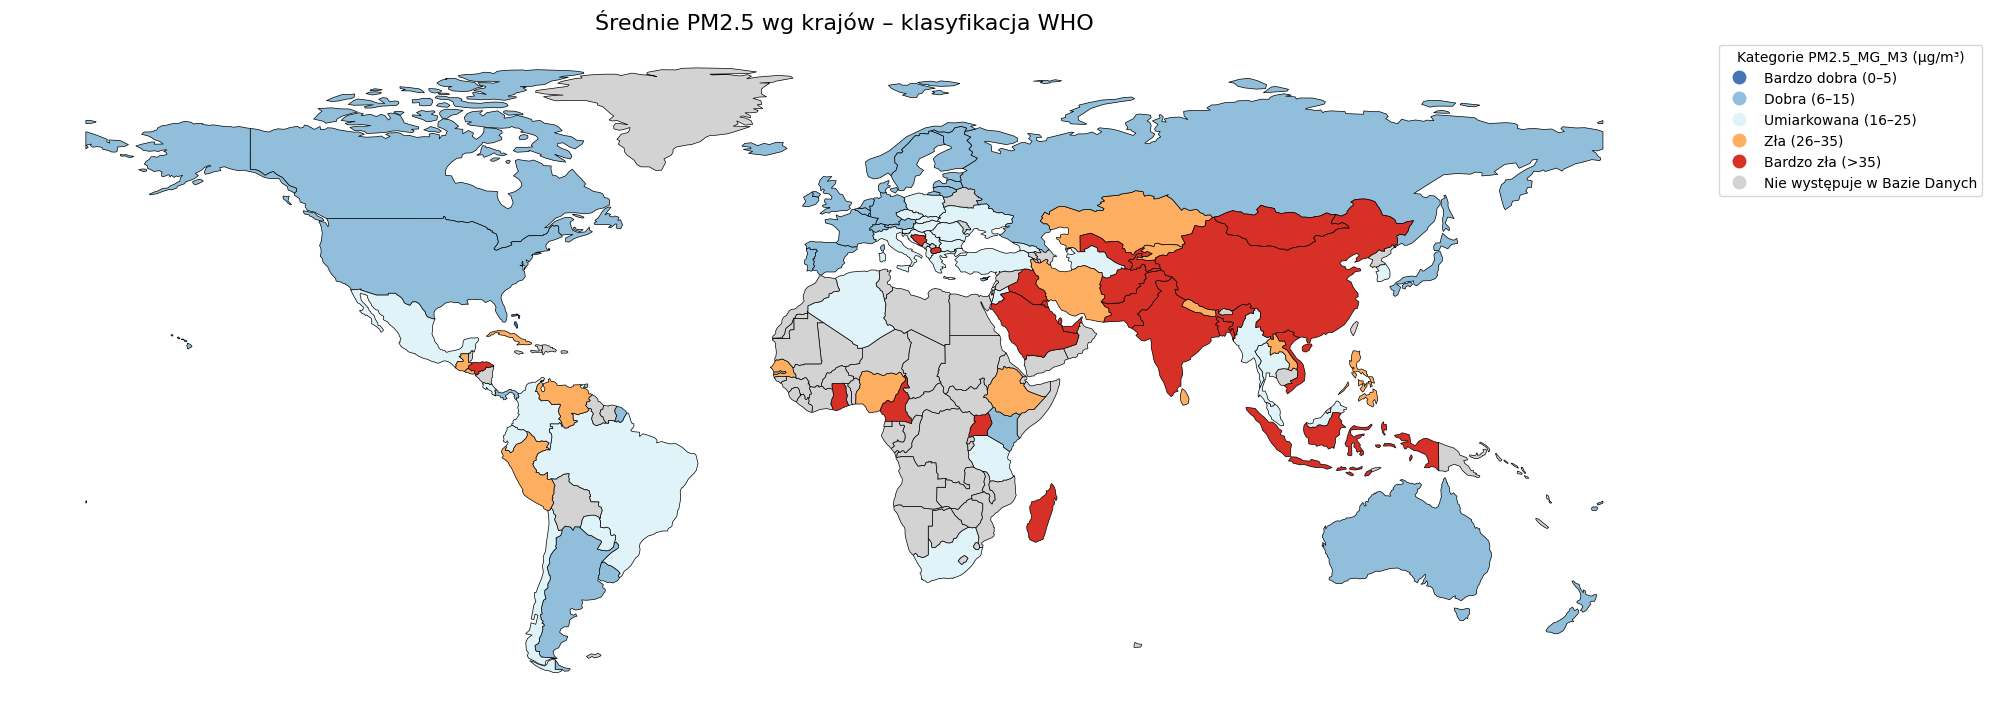

In [27]:
from utilities import plot_air_quality_map, plot_region_level_map
dane = plot_air_quality_map(
    df=df,
    value_col="pm2.5_μg_m3",
    title="Średnie PM2.5 wg krajów – klasyfikacja WHO",
    filename="mapa_pm10.png",
    bins=[0, 5, 15, 25, 35, float("inf")],
    labels=[
        "Bardzo dobra (0–5)",
        "Dobra (6–15)",
        "Umiarkowana (16–25)",
        "Zła (26–35)",
        "Bardzo zła (>35)"
    ]
)
dane = dane[['who_country_name','category']]

Tylko jeden Kraj trzyma się standardów WHO...

In [28]:
dane[dane['category'] == 'Bardzo dobra (0–5)']

,who_country_name,category
19,Bahamas,Bardzo dobra (0–5)


Wygląda na to, że kraje wysoko rozwinięte

- Stany Zjednoczone
- Polska
- Niemcy
- Szwecja

i wiele innych krajów 'Zachodnich' udostępniło niewiele danych o stanie PM2.5.

Polska dla przykładu, ma dziesiątki stacji pomiarowych do badania poziomów PM10 i PM2.5 nie tylko państwowych ale i prywatnych.

Możliwe, że niektóre kraje specjalnie nie udostępniają danych do WHO, ponieważ są świadome słabych jakości powietrza.

Klaster Azjatycki (Chiny i sąsiedzi) i Kraje Afrykańskie miały dostępność danych na poziomie Bardzo Dobrym.

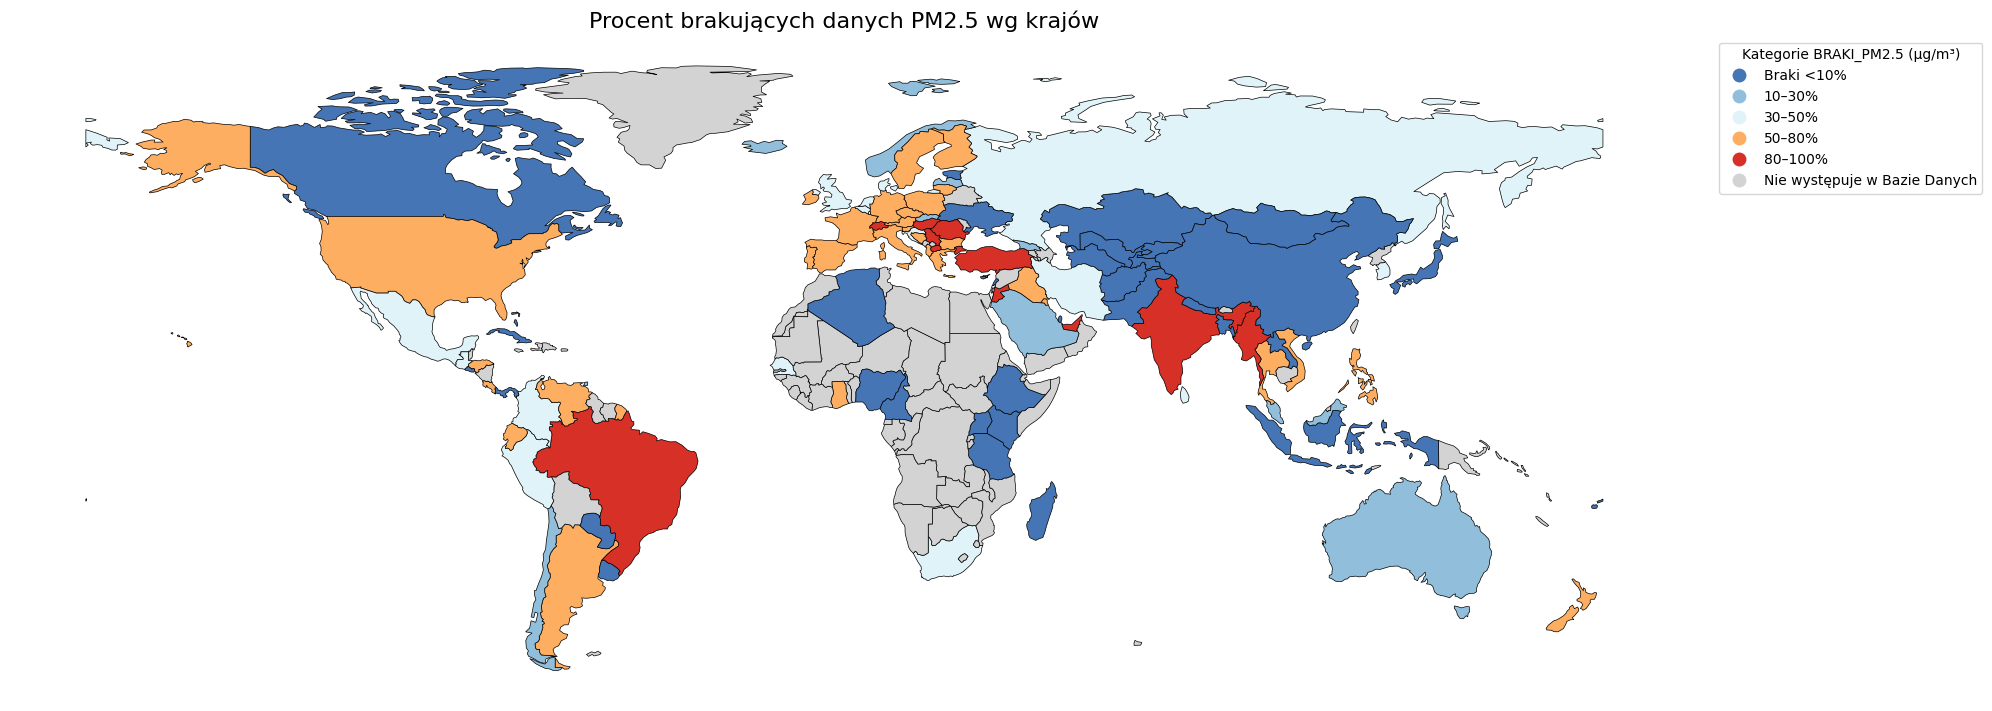

In [29]:
missing_pm25 = (
    df.groupby(["iso3", "who_country_name"])["pm2.5_μg_m3"]
    .apply(lambda x: x.isna().mean() * 100)
    .reset_index(name="braki_pm2.5")
)
dane = plot_air_quality_map(
    df=missing_pm25,
    value_col="braki_pm2.5",
    title="Procent brakujących danych PM2.5 wg krajów",
    filename="braki_pm10.png",
    bins=[-1, 10, 30, 50, 80, 99],
    labels=[
        "Braki <10%",
        "10–30%",
        "30–50%",
        "50–80%",
        "80–100%"
    ],
    cmap_colors=["#4575b4", "#91bfdb", "#e0f3f8", "#fdae61", "#d73027", "lightgrey"]
)
dane = dane[['who_country_name','category']]

Większość Krajów Afrykańskich, Środkowej Azji, Wschodniej Europy nawet nie występuje w zbiorze danych.

Kraje gdzie są dane, czyli kraje obu Ameryk, Europy Środkowej i Zachodniej są klasyfikowane jako Dobre i Bardzo Dobre.

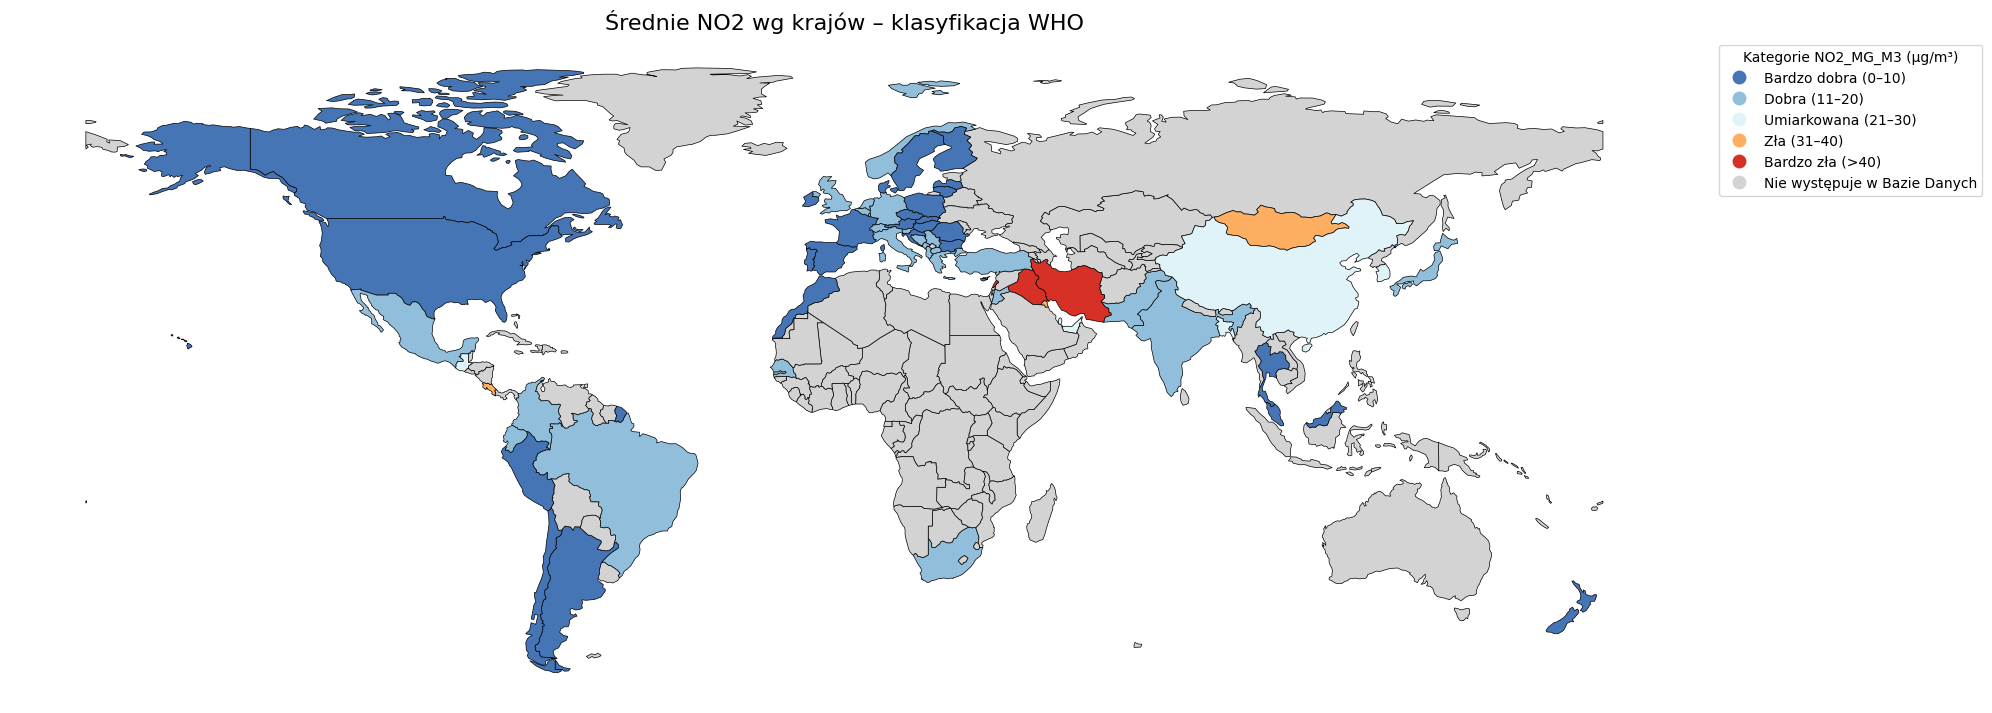

In [30]:
from utilities import plot_air_quality_map, plot_region_level_map
dane = plot_air_quality_map(
    df=df,
    value_col="no2_μg_m3",
    title="Średnie NO2 wg krajów – klasyfikacja WHO",
    filename="mapa_pm10.png",
    bins=[10, 20, 30, 40, 50, float("inf")],
    labels=[
        "Bardzo dobra (0–10)",
        "Dobra (11–20)",
        "Umiarkowana (21–30)",
        "Zła (31–40)",
        "Bardzo zła (>40)"
    ]
)
dane = dane[['who_country_name','category']]

Niewiele krajów, zaklasyfikowano jako Złe lub Bardzo Złe i są to wyłącznie kraje bez dużego przemysłu i urbanizacji.

Co może wskazywać na to że kraje wysoko rozwinięte nauczyły się już rozwijać przemysł bez ekstensywnej emisji Dwutlenku Azotu.

In [31]:
dane[dane['category'] == 'Bardzo zła (>40)']

,who_country_name,category
77,Lebanon,Bardzo zła (>40)
87,Iraq,Bardzo zła (>40)
107,Iran (Islamic Republic of),Bardzo zła (>40)


In [32]:
dane[dane['category'] == "Zła (31–40)"]

,who_country_name,category
34,Costa Rica,Zła (31–40)
86,Kuwait,Zła (31–40)
97,Mongolia,Zła (31–40)


Najlepsza dostępność danych obserwowana jest w krajach Zachodniej Europy i o dziwo w Indiach.

Poza tym nie widać większych istotnych zależności przestrzennych.

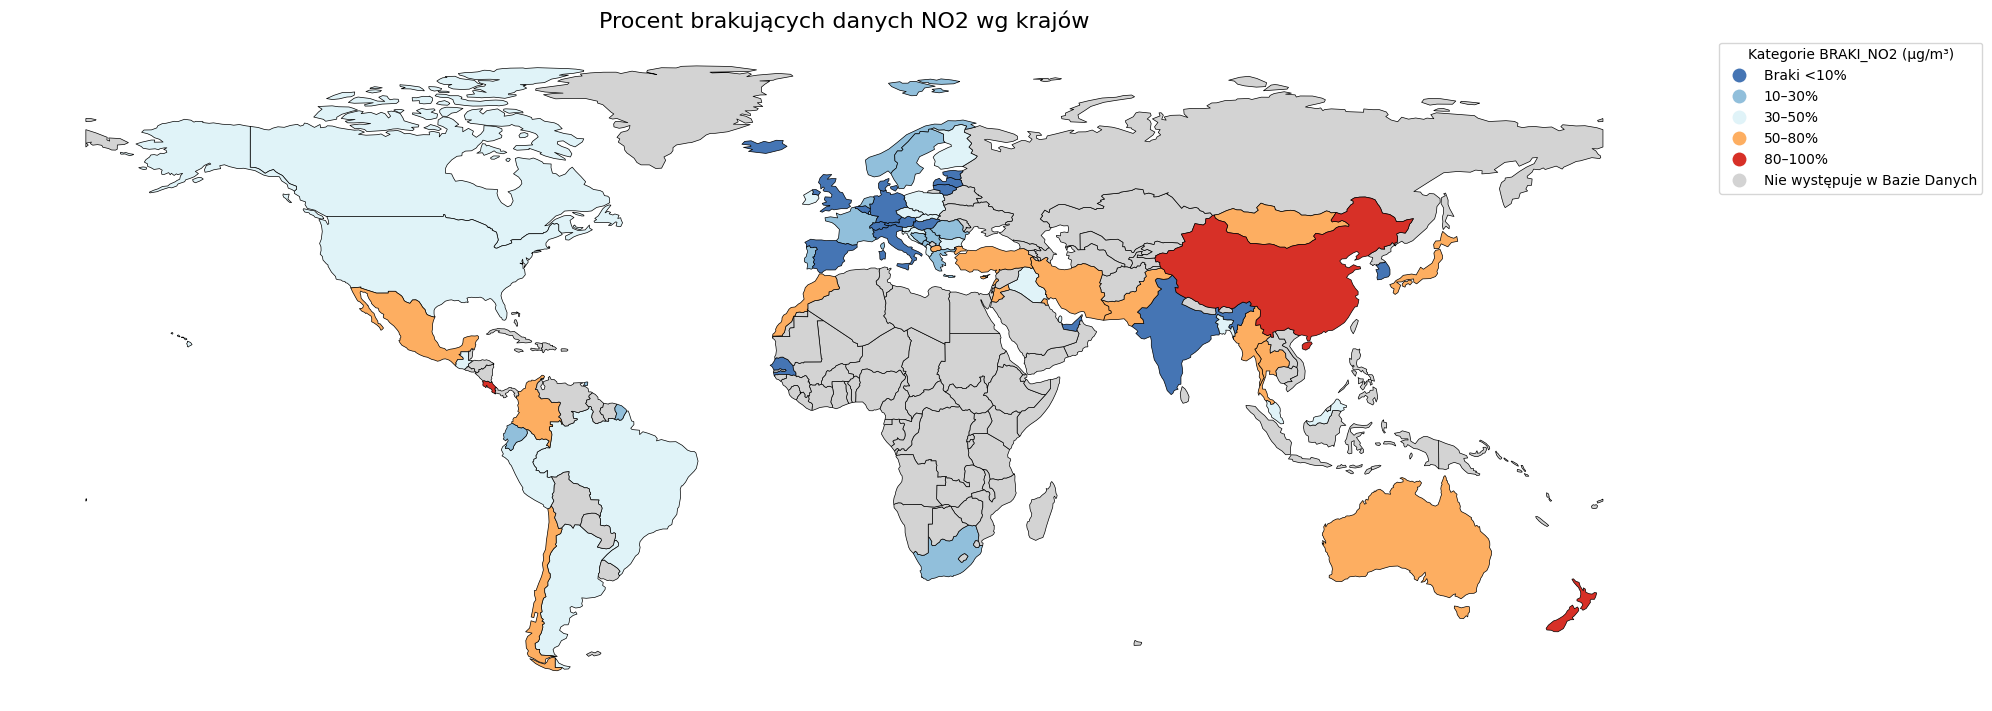

In [33]:
missing_no2 = (
    df.groupby(["iso3", "who_country_name"])["no2_μg_m3"]
    .apply(lambda x: x.isna().mean() * 100)
    .reset_index(name="braki_no2")
)
dane = plot_air_quality_map(
    df=missing_no2,
    value_col="braki_no2",
    title="Procent brakujących danych NO2 wg krajów",
    filename="braki_pm10.png",
    bins=[-1, 10, 30, 50, 80, 99],
    labels=[
        "Braki <10%",
        "10–30%",
        "30–50%",
        "50–80%",
        "80–100%"
    ],
    cmap_colors=["#4575b4", "#91bfdb", "#e0f3f8", "#fdae61", "#d73027", "lightgrey"]
)
dane = dane[['who_country_name','category']]

### <strong>Poziom - Regiony</strong>

Na poziomie regionalnym, skupiono się w mniejszym stopniu na analizie map i ponownie użyto klasycznego EDA (wykresy boxplotów).

Mapy regionalne przedstawiają podobne zależności, które było widać na poziomie krajowym.



Przekształcenie danych na potrzeby funkcji do tworzenia boxplotów.

Tak wyglądają <strong>Regiony WHO.</strong>

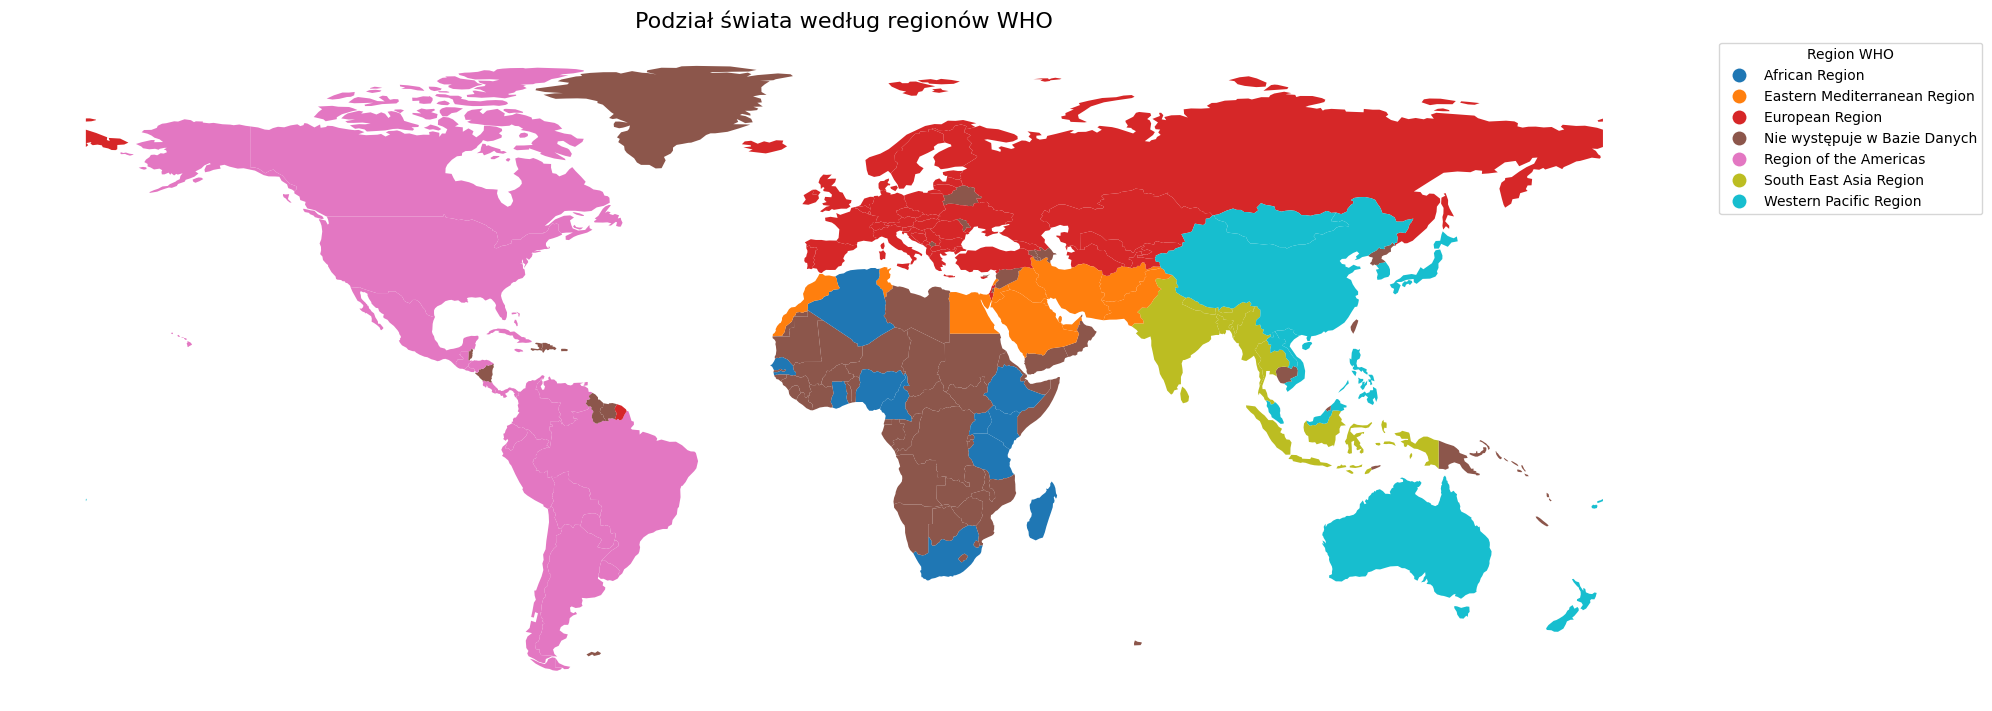

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Mapa świata
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[world["name"] != "Antarctica"]
world["geometry"] = world["geometry"].buffer(0)  # <-- naprawa geometrii

# Mapowanie ISO3 → Region WHO
country_region = df[["iso3", "who_region"]].drop_duplicates()
world = world.merge(country_region, how="left", left_on="iso_a3", right_on="iso3")
world["who_region"] = world["who_region"].fillna("Nie występuje w Bazie Danych")

# Rysowanie
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(column="who_region", ax=ax, cmap="tab10", legend=True,
           legend_kwds={"title": "Region WHO", "bbox_to_anchor": (1.02, 1), "loc": "upper left"})
ax.set_title("Podział świata według regionów WHO", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("mapa_regiony_who.png")
plt.show()


Rozkład danych jest bardzo nierówny pomiędzy regionami, większość nie-null wartości pomiarowych pochodzi z Regionu Europejskiego bo aż 40827 pomiarów.

W porównaniu z Afrykanskiego Regionu pochodzi 409. Jest to bardzo słaba próba reprezentacyjna.

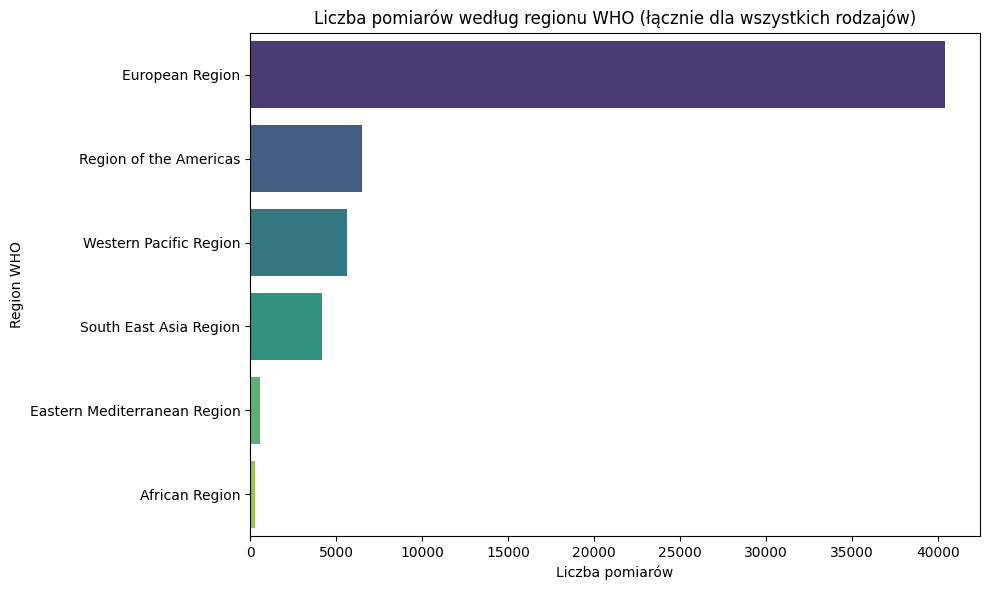

In [35]:
# Zliczamy liczbę wszystkich niepustych wartości w kolumnach pomiarowych, pogrupowane według regionu
region_counts = df.groupby("who_region")[["pm2.5_μg_m3", "pm10_μg_m3", "no2_μg_m3"]].count()
region_counts["total"] = region_counts.sum(axis=1)
region_counts = region_counts["total"].sort_values(ascending=False).reset_index()

# Wykres słupkowy
plt.figure(figsize=(10, 6))
sns.barplot(data=region_counts, x="total", y="who_region", palette="viridis")
plt.title("Liczba pomiarów według regionu WHO (łącznie dla wszystkich rodzajów)")
plt.xlabel("Liczba pomiarów")
plt.ylabel("Region WHO")
plt.tight_layout()
plt.show()


In [36]:
region_counts

,who_region,total
0,European Region,40431
1,Region of the Americas,6521
2,Western Pacific Region,5663
3,South East Asia Region,4175
4,Eastern Mediterranean Region,565
5,African Region,313


Przekształcenie danych na potrzeby funkcji plot_region_boxplots

In [37]:
from utilities import plot_region_boxplots
df_long = df.melt(
    id_vars=["who_region", "measurement_year"],
    value_vars=["pm2.5_μg_m3", "pm10_μg_m3", "no2_μg_m3"],
    var_name="pollutant",
    value_name="value"
).dropna(subset=["value"])

### Analiza Rozkładów Danych Pomiarowych  - w czasie, w obrębie jednego regionu

<strong>European Region</strong>

W regionie Europejskim, zaobeserwowano wiele outlierów szczególnie dla danych pomiarowych PM10 na przestrzeni wszystkich lat poza 2011.

Widać również trend spadkowy. Boxy przesuwają się ku dołowi na przestrzeni wszystkich pomiarów z lekką fluktuacją w latach 2015-2018.

Dla wszystkich 3 pomiarów, jakość powietrza poprawiła się pomiędzy 2010 a 2019 rokiem.

Poziomy PM10 są podobne, lecz trochę niższe od NO2. Naturalnie, PM2.5 ma najniższe poziomy, ponieważ jest podzbiorem PM10 więc należy się tego spodziewać.


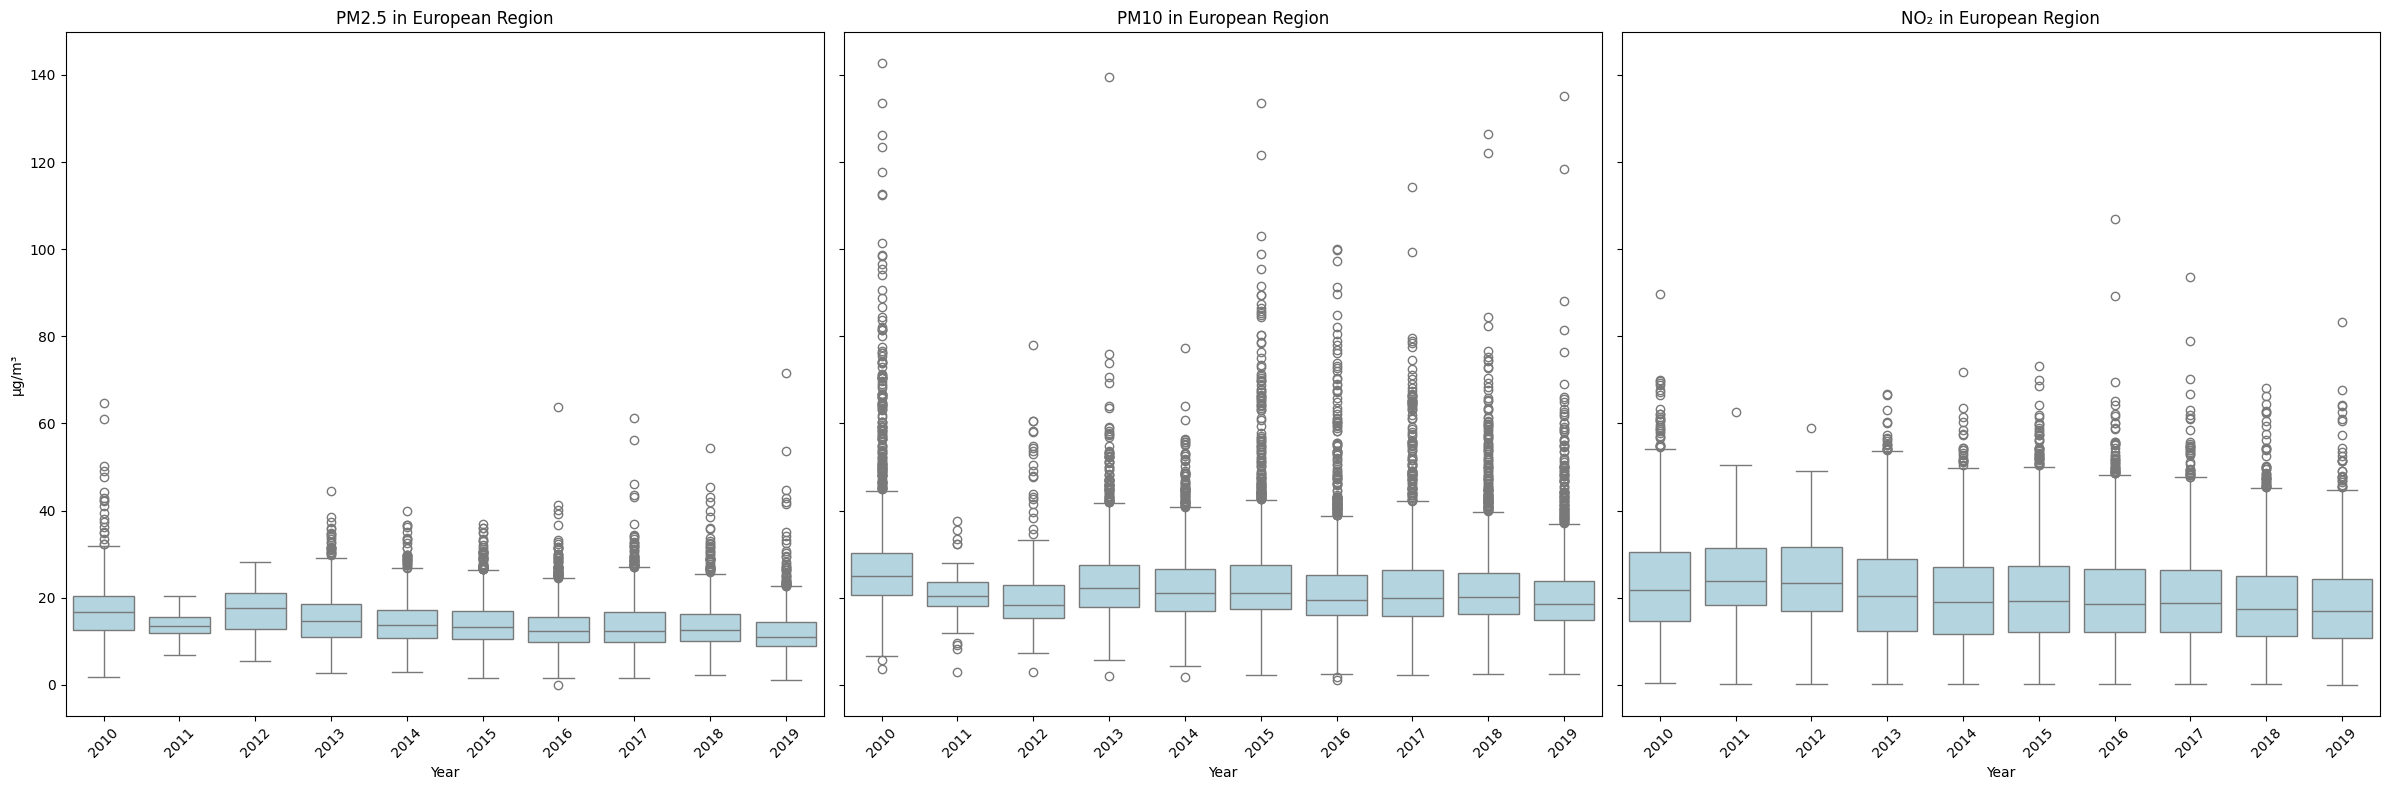

In [38]:
plot_region_boxplots(df_long, "European Region")

<strong>Region of the Americas</strong>

Region Ameryk ma również tendencję spadkową na przestrzeni lat dla 3 pomiarów.

Jest najbardziej zanieczyszczony przez PM10. Co sugeruje, dużo źródeł emisji naturalnych jak np: wybuchy wulkanów, burze piaskowe, pożary lasów etc.

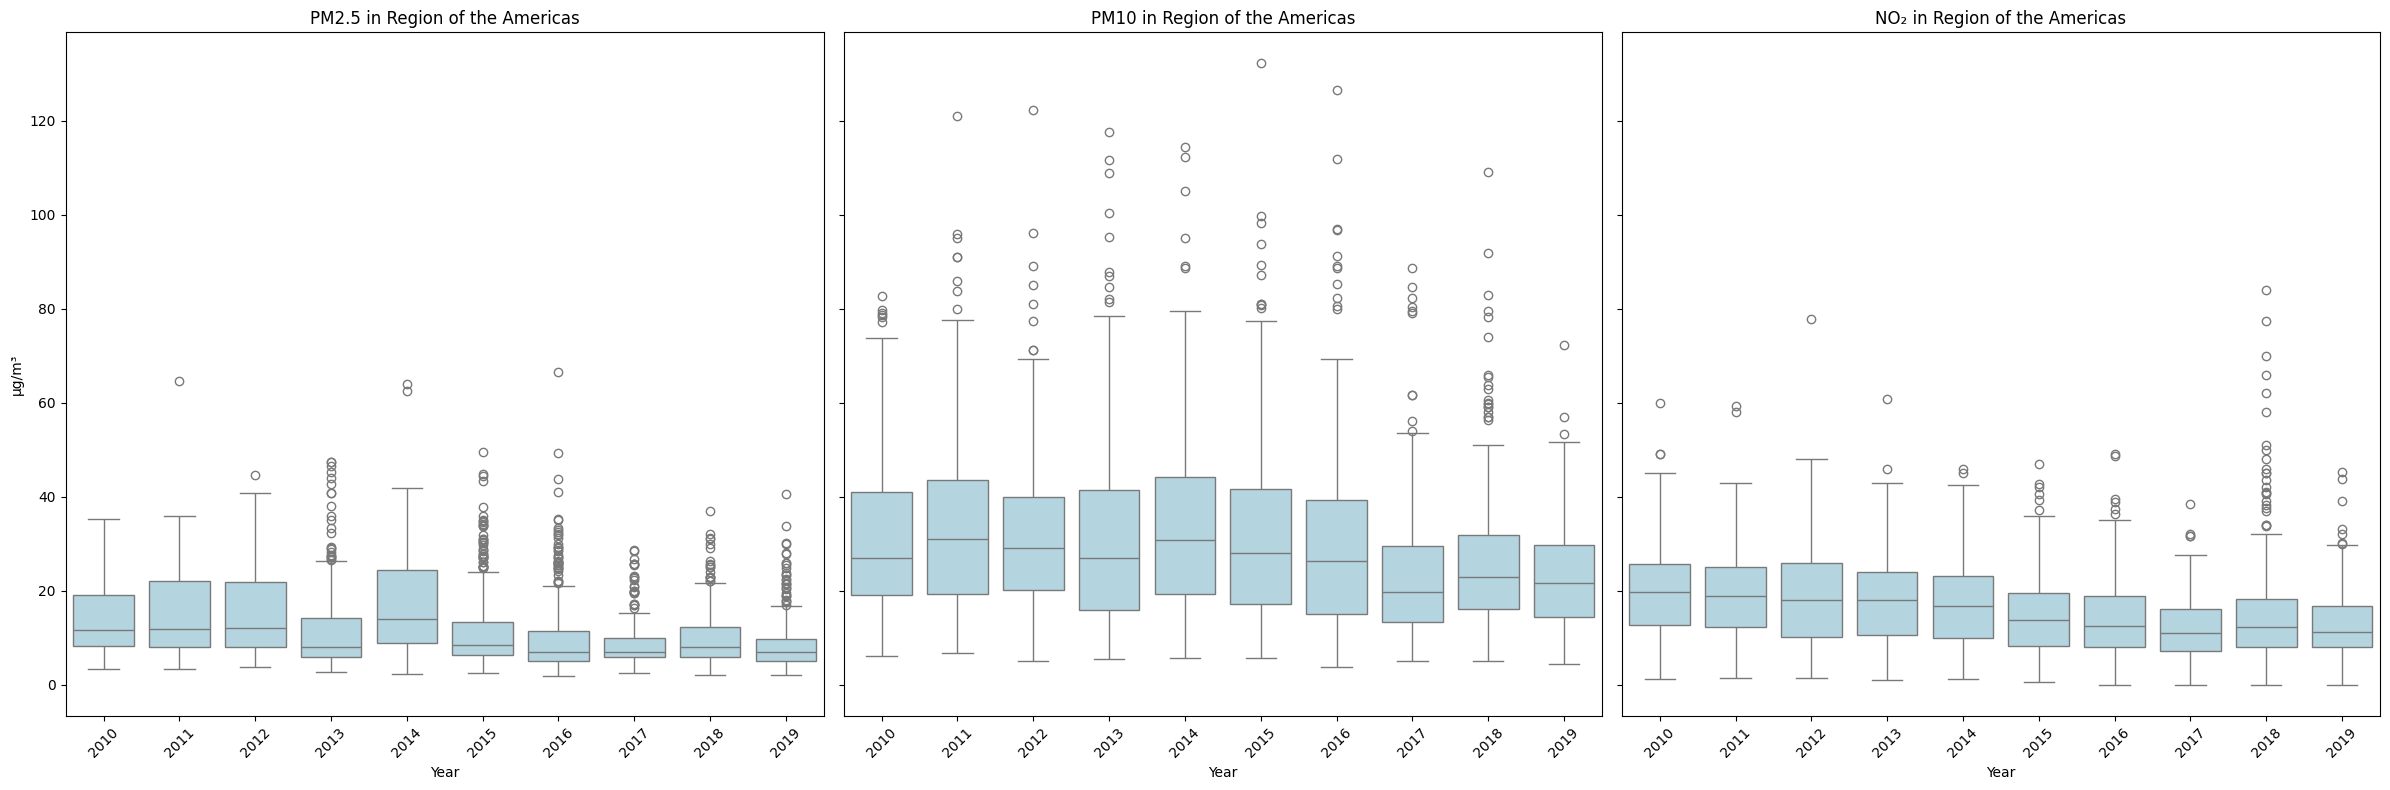

In [39]:
plot_region_boxplots(df_long, "Region of the Americas")

<strong>Western Pacific Region</strong>

Region Zachodniego Pacyfiku nie ma trend spadkowy tylko dla dwutlenku azotu, gdzie występuje też bardzo niewielka ilość outlierów.

PM10 utrzymuje się na podobnym poziomie dla wszystkich lat, aczkolwiek box 2019 jest niżej niż 2010.

PM2.5 zaliczyło gwałtowny wzrost pomiędzy 2012 a 2013 co sugeruje rozwój przemysłu i urbanizacji, w późniejszych lat poziom zaczyna lekko opadać.

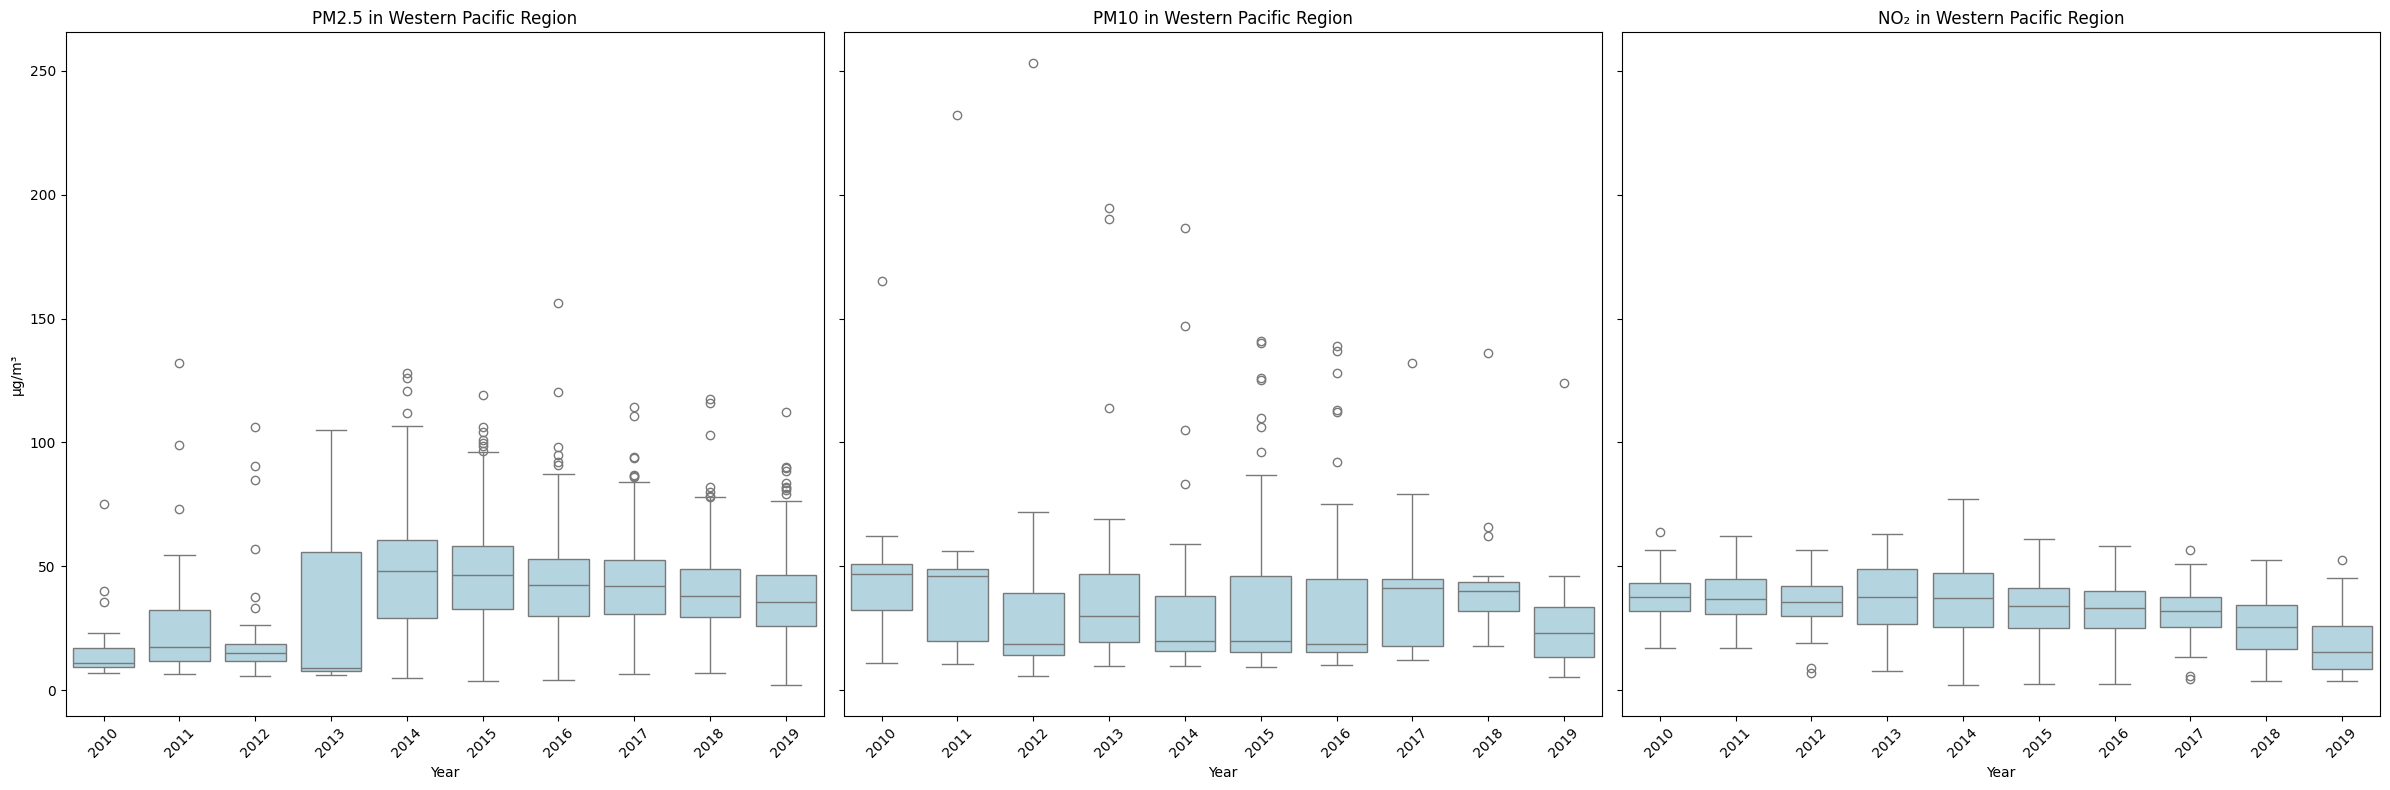

In [40]:
plot_region_boxplots(df_long, "Western Pacific Region")

<strong>South East Asia Region</strong>

Południowo-Wschodnia Azja, miała zanotowane wyjątkowo wysokie poziomy PM2.5 w okresie 2010-2015, po czym nastąpił gwałtowny spadek.

Pomiary PM10 utrzymują się na wysokich poziomach, nie zanotowano wyraźnej tendencji spadkowej.

Poziomy Dwutlenku Azotu są zaskakująco niskie w porównaniu do pozostałych dwóch poziomów.

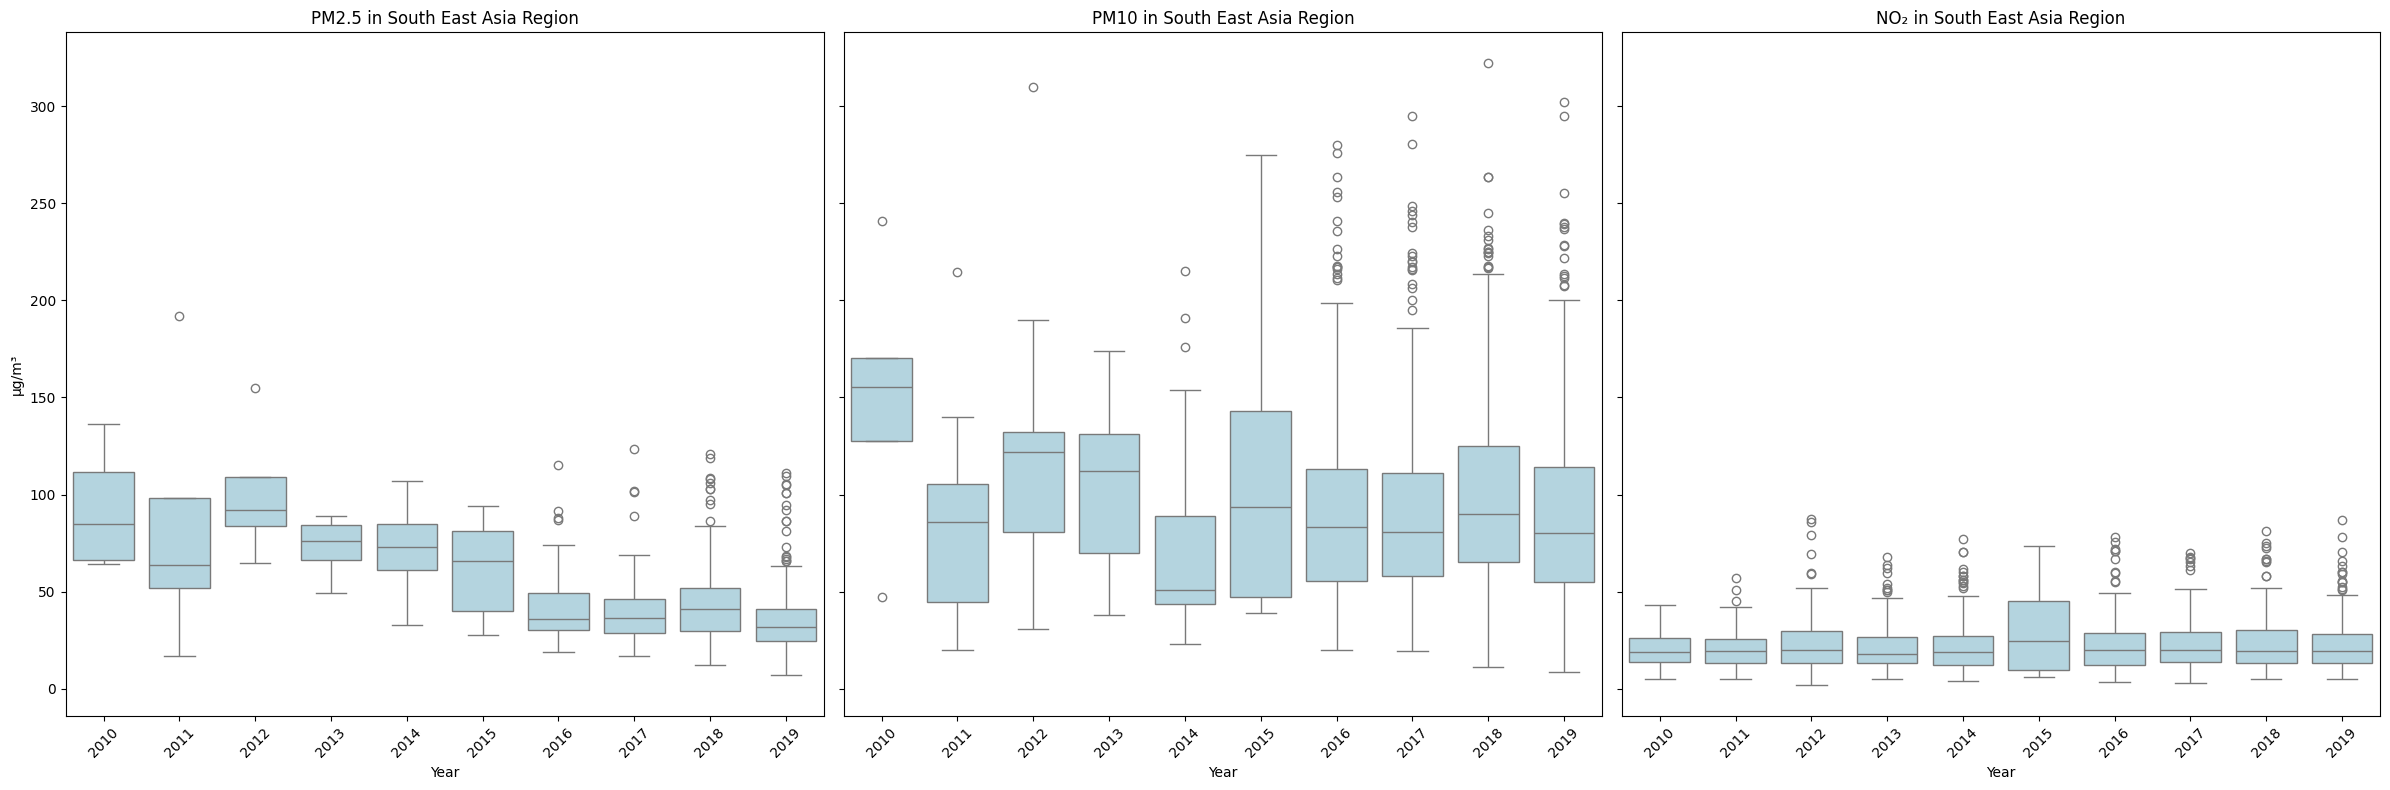

In [41]:
plot_region_boxplots(df_long, "South East Asia Region")

<strong>Eastern Mediterranean Region</strong>

Region wschodniośródziemnomorski, należy pamiętać, że ilość pomiarów jest niewielka i może to niepoprawnie odzwierciedlać rzeczywistość.

PM2.5 w 2010 mediana była wyższa niż 100, po czym nastąpił spadek do 45 i utrzymał się w latach 2011-2019. Sytuacja i tak ma się gorzej w porównaniu z Europą i Amerykami.

PM10 mediana również utrzymywała się na poziomie około 100 na przestrzeni lat, aczkolwiek boxy przesuwają się lekko ku dołowi z biegiem lat.

NO2 notowana stabilnie na niskim poziomie w porównaniu z pomiarami PM.

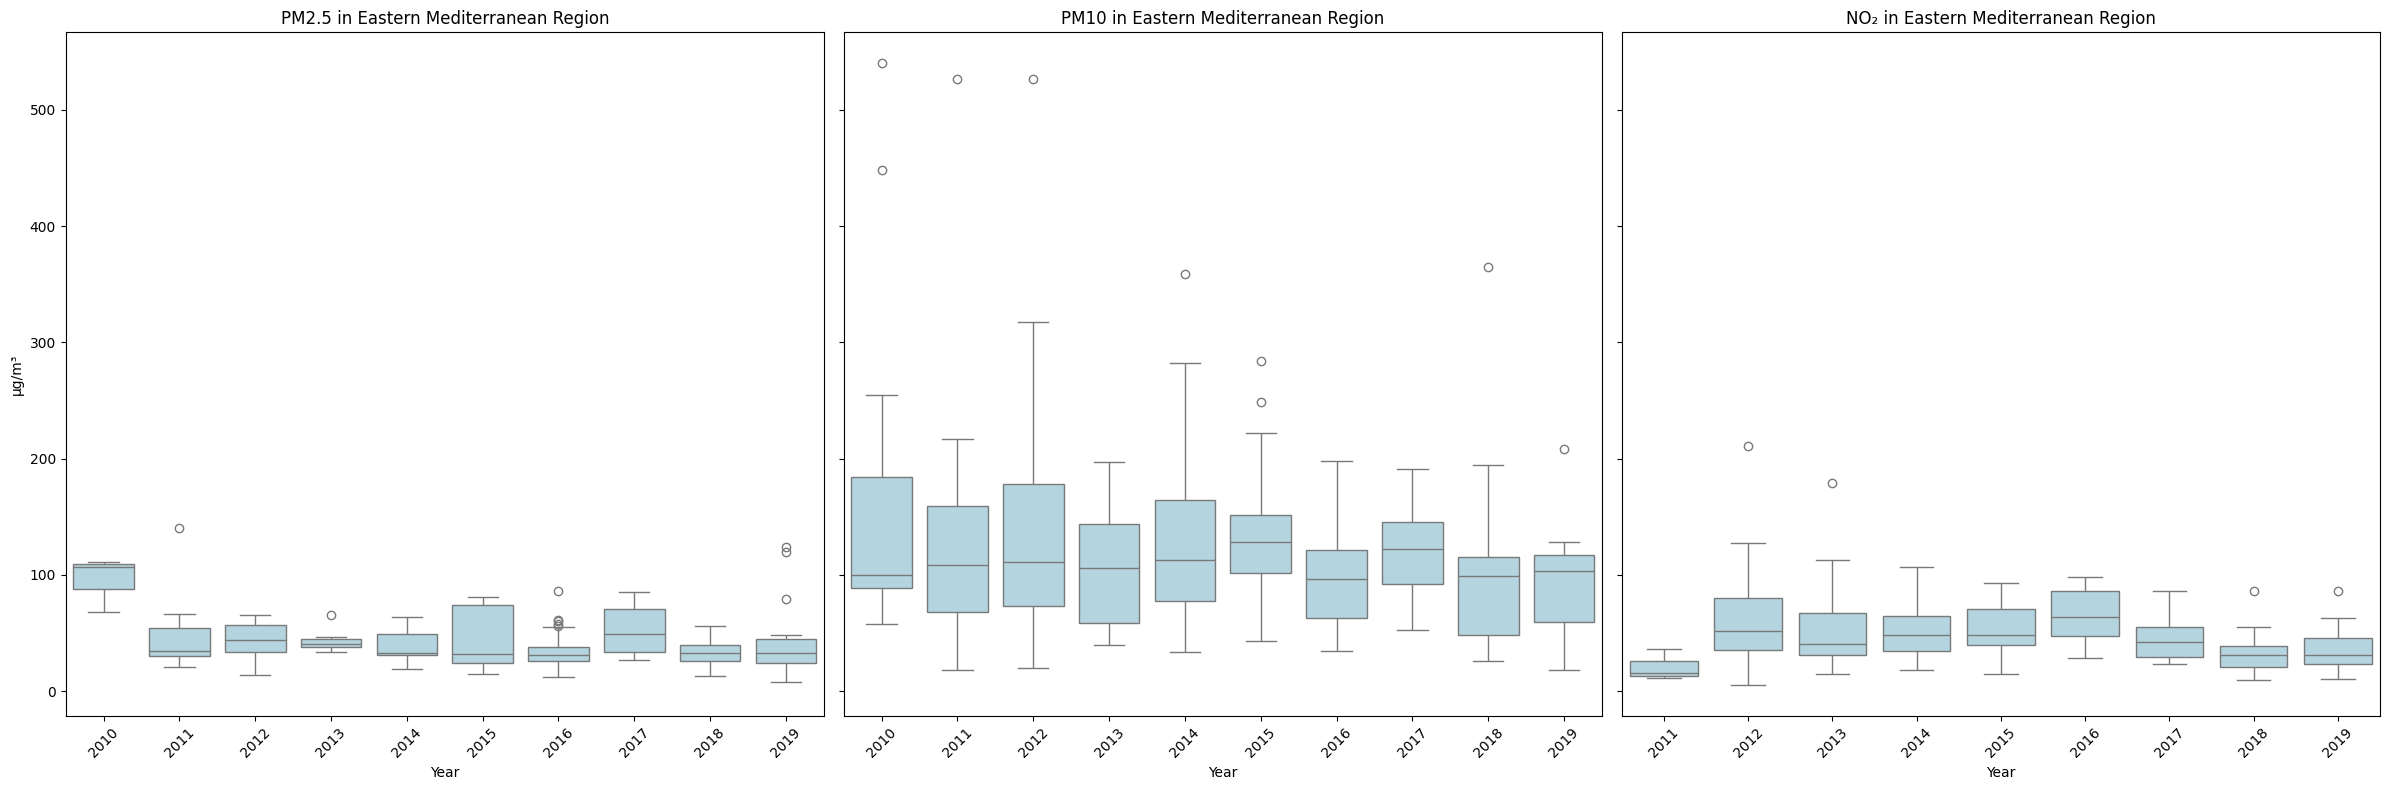

In [42]:
plot_region_boxplots(df_long, "Eastern Mediterranean Region")

<strong>African Region</strong>

Region Afrykański, ma jedynie 409 danych pomiarowych dlatego jego analiza została pominięta, ponieważ niemożliwym jest, żeby tak niewielka ilość pomiarów poprawnie odzwierciedlała stan jakości powietrza tak ogromego regionu.

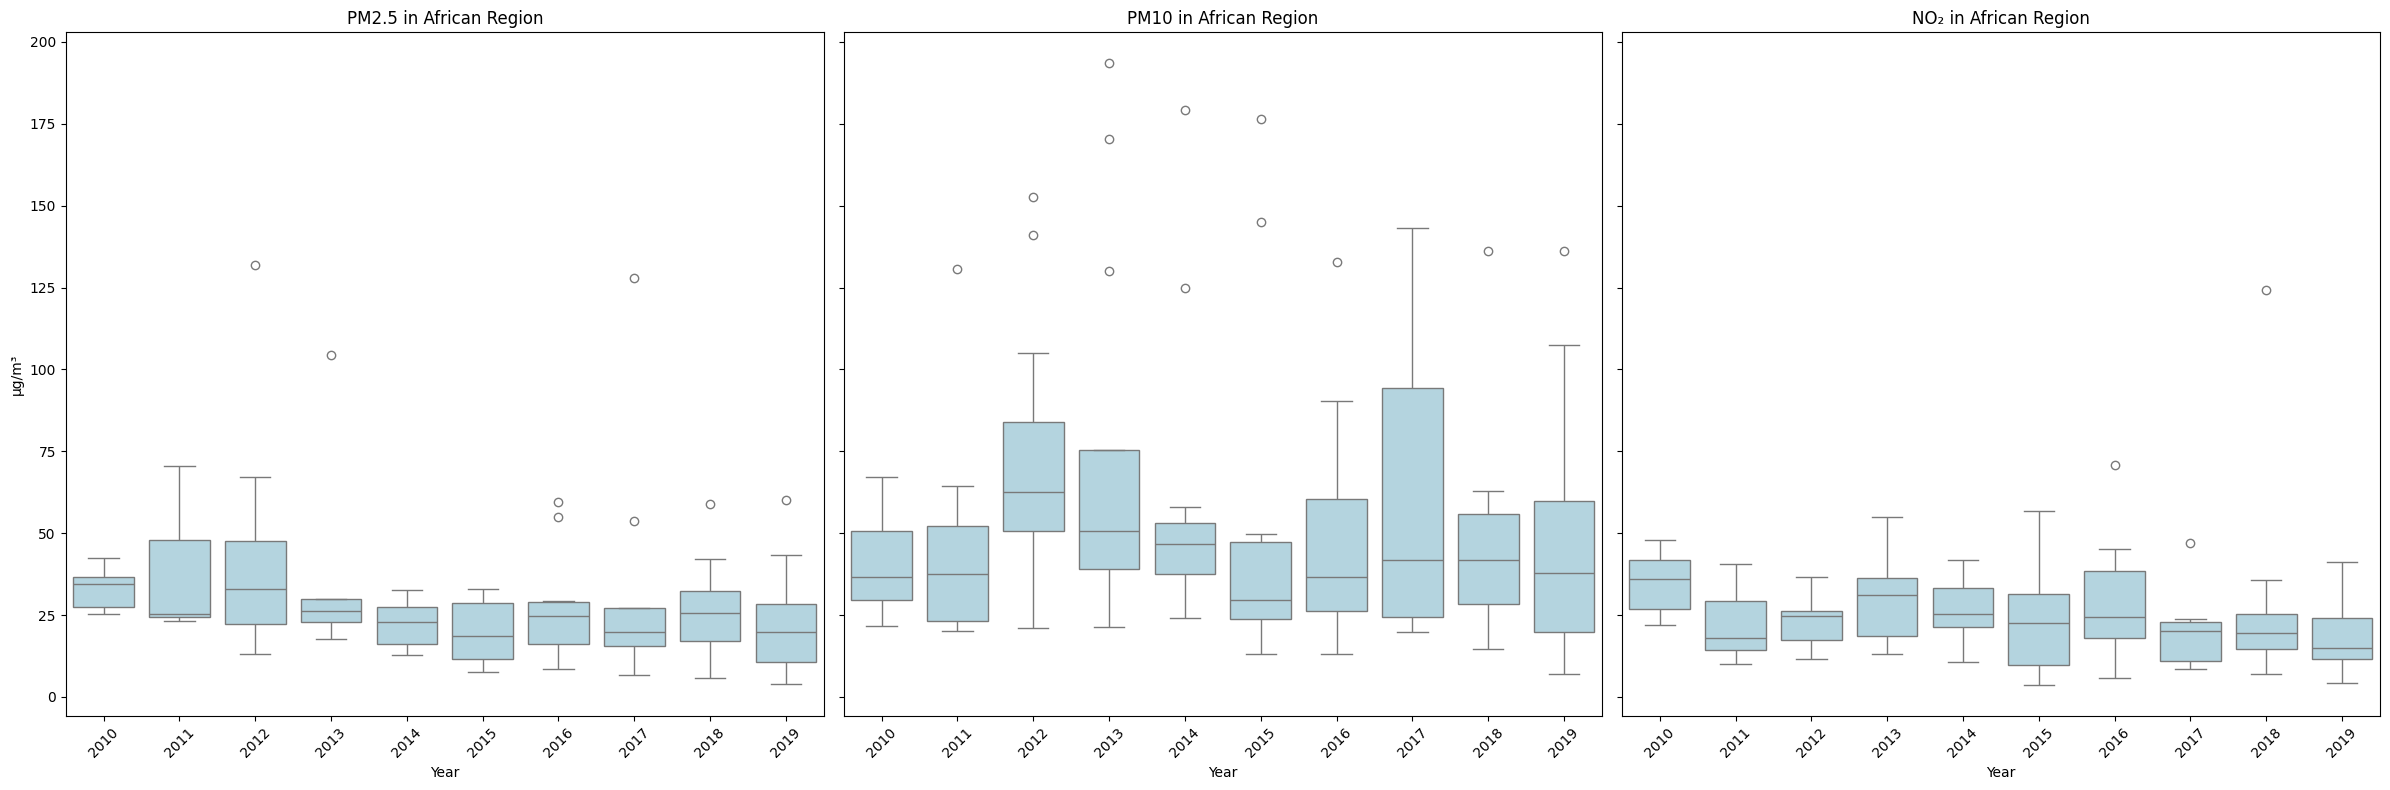

In [43]:
plot_region_boxplots(df_long, "African Region")

## 3. Podsumowanie

### 3.1 Wnioski z EDA.

Zbiór jest nierównomierny pod względem rozłożenia danych pomiędzy regionami. Ma bardzo wiele wartości brakujących, pomimo faktu iż każdy kraj (przynajmniej te wysoko rozwinięe) dysponuje wieloma stacjami pomiarowymi. 

Bardzo możliwe, że występuje aspekt polityczny gdzie dane są przekłamywane lub ukrywane przed WHO przez niektóre państwa, co wpływa na prawdziwość danych i to w jaki sposób odzwierciedlają faktyczny stan powietrza.

Pomimo tych wad, zbiór może być przydatny w analize globalnych trendów ochrony środowiska i rozwoju przemysłu.

Nie-zależnie od poziomu generalizacji, aby móc w pełni badać zależności w zbiorze danych, wymagana jest szeroka wiedza geopolityczna, której autor nie posiada.

Zależnie od poziomu generalizacji, wizualizacja poprzez mapy może być bardzo-trudna i czasochłonna (na poziomie miast praktycznie niemożliwa dla jednej osoby) lub dużo prostsza np. dla analizy regionów (można się skupić na zmienności czasowej).

Na poziomie krajowym, zwracano uwagę na skupienia w badanych wymiarach i jakie przyjmowały kategorie. Analiza i interpretacja zależności dla każdego kraju z osobna byłaby ekstremalnie trudna.

### 3.2 Zastosowanie w Uczeniu Maszynowym

Autor, uważa że jest to bardzo słaby zbiór do wykorzystania w <strong>uczeniu maszynowym</strong>. 

Zbiór wymaga dużo preprocessingu i zaawanosowanych metod imputacji, najplepiej opartych o zależności przestrzenne (imptutacja wewnątrz państwowa).

Dane zostały uśrednione rocznie, choć zwykle dane pomiarowe zbierane są w interwałach dziennych. Więc każde państwo/instytucja dysponuje tymi bardziej dokładnymi danymi, które lepiej sprawdziły by się w <strong>uczeniu maszynowym</strong>.

Analiza dla całego świata jest bardzo wymagającym zadaniem, wiedząc, że nawet analiza jedneo kraju może zająć tygodnie jak nie miesiące :>.

<strong>Generalnie Fajny Projekt, Pozdrawiam Tymoteusz Morawiec</strong>